<font color = 'blue'>

## High Risk Churn Customers Prediction 


</font>


<font color = 'red'>
    
#### In this highly competitive market, telecommunications industry experiences an average of 15-25% annual churn rate. Retaining high profitable customers is very important to survive in the industry. In this project, we analyzed customer-level data of a leading telecom firm and built predictive models to identify customers at high risk of churn and identify the main indicators of churn.
</font>

In [2]:
from datetime import datetime
startTime = datetime.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#! pip install imblearn
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
#from sklearn.pipeline import Pipeline
from sklearn.decomposition import IncrementalPCA # perform PCA with n components
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier # random forest classifier from sklearn library
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, make_scorer
import joblib
import gc
%matplotlib inline

In [3]:
# read data set
df = pd.read_csv('data/telecom_churn_data.csv')

In [4]:
# shape of the dataset
df.shape

(99999, 226)

In [5]:
# space used by training data
print('Training dataset uses {0} MB'.format(df.memory_usage().sum()/1024**2))

Training dataset uses 172.42271423339844 MB


In [6]:
# information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [7]:
# set the limit for display columns as 300 to check all columns
pd.set_option("display.max_columns", 300)

In [8]:
# check the top 5 rows of the data set
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [9]:
# Check the unique value of the mobile_number
len(df['mobile_number'].unique())

99999

In [10]:
# check the unique value of the circle_id
len(df['circle_id'].unique())

1

In [11]:
# drop circle_id, as this complete data set is from one circle ID. 
# also can drop mobile number, which represents each user, as it is not important to track user identification.
df.drop(columns = ['mobile_number','circle_id'], inplace = True) 

In [12]:
df_missing_col_perc = round(df.isnull().sum()/len(df.index)*100,2).sort_values(ascending = False).reset_index()
df_missing_col_perc.columns = ['Features','% of missing data']
df_missing_col_perc

,Features,% of missing data
0,date_of_last_rech_data_6,74.85
1,arpu_2g_6,74.85
2,count_rech_3g_6,74.85
3,night_pck_user_6,74.85
4,count_rech_2g_6,74.85
...,...,...
219,total_ic_mou_9,0.00
220,total_ic_mou_8,0.00
221,total_ic_mou_7,0.00
222,total_ic_mou_6,0.00


In [13]:
# filter the missing values with 5%. for better visulization
df_missing_col_perc_fil = df_missing_col_perc.loc[df_missing_col_perc['% of missing data']>5]

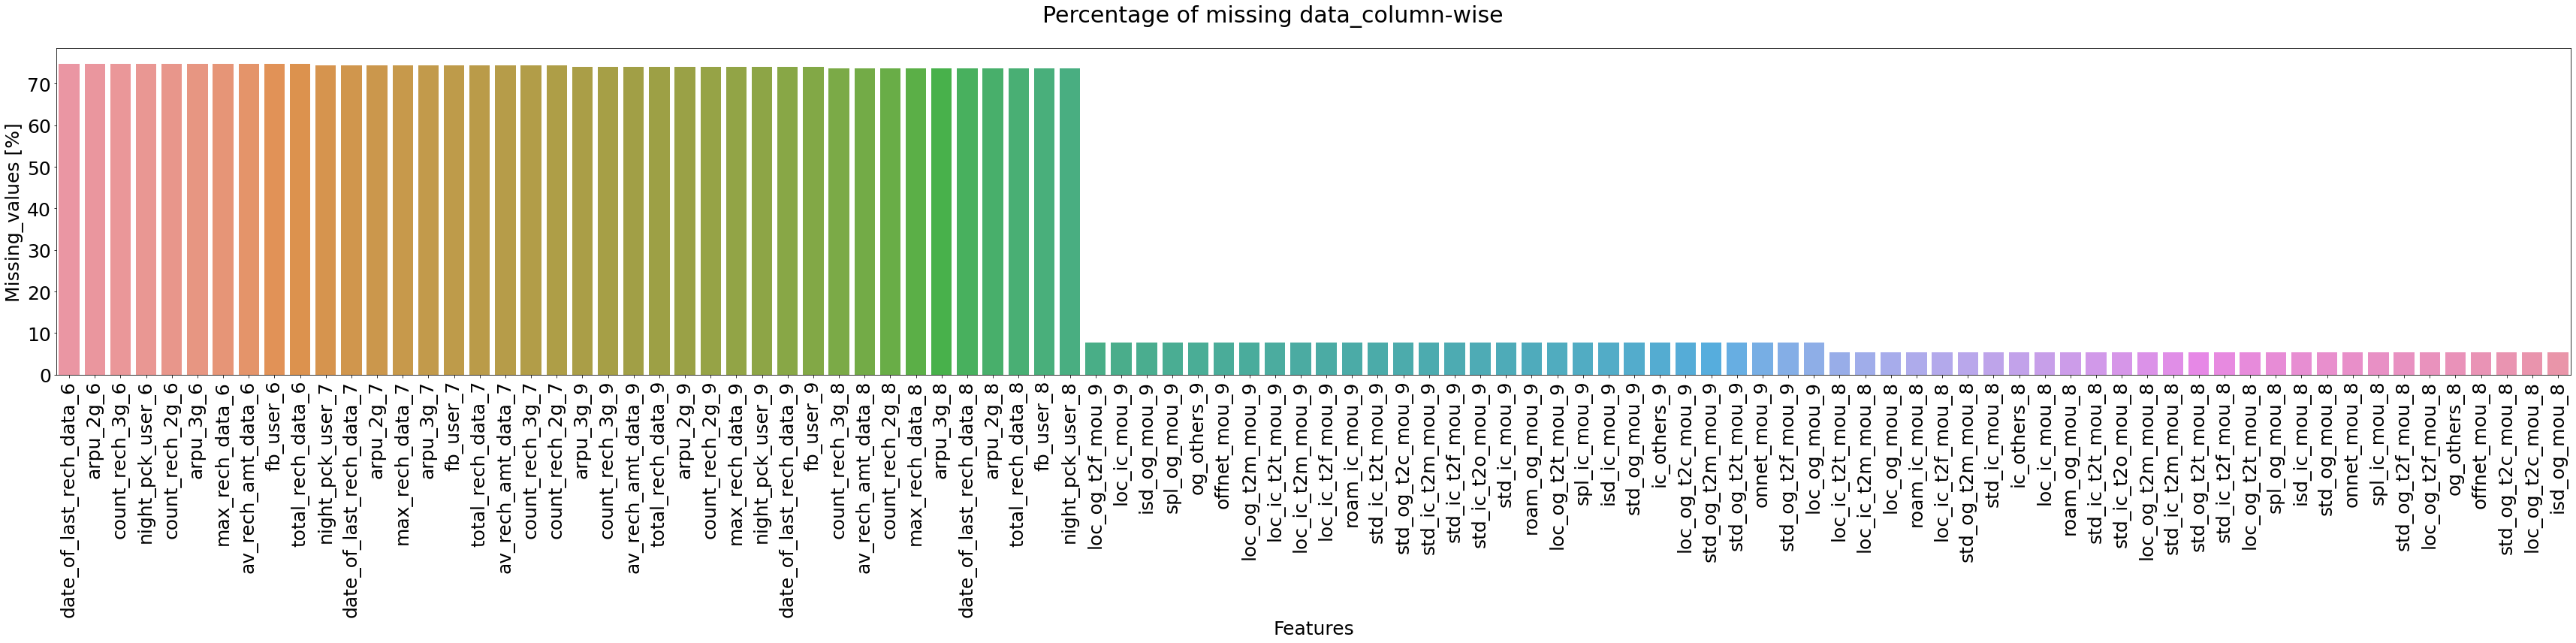

In [14]:
# plot the original data set missing values percentage 
plt.figure(figsize = (60,8))
fig = sns.barplot(x = 'Features', y = '% of missing data', data = df_missing_col_perc_fil)

plt.xticks(rotation=90)
plt.suptitle('Percentage of missing data_column-wise', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Missing_values [%]',fontsize = 25)
plt.xlabel('Features',fontsize = 25)
plt.show()

In [15]:
# noticed that from each month, there are certain columns having more than 70% missing values. lets check those columns from JUN
df_missing_col_perc[:10]

,Features,% of missing data
0,date_of_last_rech_data_6,74.85
1,arpu_2g_6,74.85
2,count_rech_3g_6,74.85
3,night_pck_user_6,74.85
4,count_rech_2g_6,74.85
5,arpu_3g_6,74.85
6,max_rech_data_6,74.85
7,av_rech_amt_data_6,74.85
8,fb_user_6,74.85
9,total_rech_data_6,74.85


In [16]:
# list of common columns other than respective month columns
com_col = [i for i in df.columns if not(re.search('(?:_6|_7|_8|_9|jun_|jul_|aug_|sep_)',i))]
print(com_col)

['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'aon']


In [17]:
df[com_col].describe()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,aon
count,98981.0,98981.0,98981.0,99999.000000
mean,0.0,0.0,0.0,1219.854749
std,0.0,0.0,0.0,954.733842
min,0.0,0.0,0.0,180.000000
25%,0.0,0.0,0.0,467.000000
50%,0.0,0.0,0.0,863.000000
75%,0.0,0.0,0.0,1807.500000
max,0.0,0.0,0.0,4337.000000


In [18]:
# drop the following columns : 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou'. since there is no variance in the data
df.drop(columns = com_col[:-1], inplace = True)

In [19]:
# list the columns related to good phase ( means from 6th & 7th month) along with common columns
good_ph_col = com_col+[i for i in df.columns if re.search('(?:_6|_7|jun_|jul_)',i)]
print(good_ph_col)

['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'aon', 'last_date_of_month_6', 'last_date_of_month_7', 'arpu_6', 'arpu_7', 'onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_6', 'isd_og_mou_7', 'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6', 'og_others_7', 'total_og_mou_6', 'total_og_mou_7', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_mou_6', 'loc_ic_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2m_mo

In [20]:
# list of churn phase columns from 9th month
churn_ph_col = [i for i in df.columns if re.search('(?:_9|sep_)',i)]
print(churn_ph_col)

['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'sep_vbc_3g']


In [21]:
# list the columns from each month to check data separately for better understanding.
jun_ph_col = [i for i in df.columns if re.search('(?:_6|jun_)',i)]
jul_ph_col = [i for i in df.columns if re.search('(?:_7|jul_)',i)]
aug_ph_col = [i for i in df.columns if re.search('(?:_8|aug_)',i)]
sep_ph_col = [i for i in df.columns if re.search('(?:_9|sep_)',i)]

In [22]:
# get the mobile data related columns from JUN month 
jun_data_col = [s for s in df[jun_ph_col].columns if re.search('(?:rech_2g|rech_3g|rech_data|rech_amt_data|arpu|user)',s)]
print(jun_data_col)

['arpu_6', 'date_of_last_rech_data_6', 'total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6']


In [23]:
# check the missing values of 'Jun_data_col' when 'date_of_last_rech_data_6' is null.
df[jun_data_col].loc[df['date_of_last_rech_data_6'].isnull()].isnull().sum()

arpu_6                          0
date_of_last_rech_data_6    74846
total_rech_data_6           74846
max_rech_data_6             74846
count_rech_2g_6             74846
count_rech_3g_6             74846
av_rech_amt_data_6          74846
arpu_3g_6                   74846
arpu_2g_6                   74846
night_pck_user_6            74846
fb_user_6                   74846
dtype: int64

In [24]:
# It is clear that, all missing values realted to mobile data is null when 'date_of_last_rech_data_6' is null. 
# This means, no recharge done. we may impute zero into all missing values from 'jun_data_col'
# Let's check for all other 3 months to conclude.

In [25]:
# get the mobile data related columns from Jul month 
jul_data_col = [s for s in df[jul_ph_col].columns if re.search('(?:rech_2g|rech_3g|rech_data|rech_amt_data|arpu|user)',s)]
print(jul_data_col)

['arpu_7', 'date_of_last_rech_data_7', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'fb_user_7']


In [26]:
# check the missing values of 'Jul_data_col' when 'date_of_last_rech_data_7' is null.
df[jul_data_col].loc[df['date_of_last_rech_data_7'].isnull()].isnull().sum()

arpu_7                          0
date_of_last_rech_data_7    74428
total_rech_data_7           74428
max_rech_data_7             74428
count_rech_2g_7             74428
count_rech_3g_7             74428
av_rech_amt_data_7          74428
arpu_3g_7                   74428
arpu_2g_7                   74428
night_pck_user_7            74428
fb_user_7                   74428
dtype: int64

In [27]:
# it is clear that, all missing values realted to mobile data is null when 'date_of_last_rech_data_7' is null. 
# this means, no recharge done. we may impute zero into all missing values from 'jul_data_col'

In [28]:
# get the mobile data related columns from Aug month 
aug_data_col = [s for s in df[aug_ph_col].columns if re.search('(?:rech_2g|rech_3g|rech_data|rech_amt_data|arpu|user)',s)]
print(aug_data_col)

['arpu_8', 'date_of_last_rech_data_8', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'arpu_3g_8', 'arpu_2g_8', 'night_pck_user_8', 'fb_user_8']


In [29]:
# check the missing values of 'Aug_data_col' when 'date_of_last_rech_data_8' is null.
df[aug_data_col].loc[df['date_of_last_rech_data_8'].isnull()].isnull().sum()

arpu_8                          0
date_of_last_rech_data_8    73660
total_rech_data_8           73660
max_rech_data_8             73660
count_rech_2g_8             73660
count_rech_3g_8             73660
av_rech_amt_data_8          73660
arpu_3g_8                   73660
arpu_2g_8                   73660
night_pck_user_8            73660
fb_user_8                   73660
dtype: int64

In [30]:
# it is clear that, all missing values realted to mobile data is null when 'date_of_last_rech_data_8' is null. 
# this means, no recharge done. we may impute zero into all missing values from 'aug_data_col'

In [31]:
# get the mobile data related columns from Sep month 
sep_data_col = [s for s in df[sep_ph_col].columns if re.search('(?:rech_2g|rech_3g|rech_data|rech_amt_data|arpu|user)',s)]
print(sep_data_col)

['arpu_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'fb_user_9']


In [32]:
# check the missing values of 'sep_data_col' when 'date_of_last_rech_data_9' is null.
df[sep_data_col].loc[df['date_of_last_rech_data_9'].isnull()].isnull().sum()

arpu_9                          0
date_of_last_rech_data_9    74077
total_rech_data_9           74077
max_rech_data_9             74077
count_rech_2g_9             74077
count_rech_3g_9             74077
av_rech_amt_data_9          74077
arpu_3g_9                   74077
arpu_2g_9                   74077
night_pck_user_9            74077
fb_user_9                   74077
dtype: int64

In [33]:
# it is clear that, all missing values realted to mobile data is null when 'date_of_last_rech_data_9' is null. 
# this means, no recharge done. we may impute zero into all missing values from 'sep_data_col'

# It is clear that all four months having same pattern, so we can impute zero in all those columns, 
# except 'date_of_last_rech_data_x', we can drop this date related columns.  

In [34]:
# combine the all four months columns excluding 'date_of_last_rech_data_x' & 'arpu_x' columns
lst_rech_missing_col = jun_data_col[2:]+jul_data_col[2:]+aug_data_col[2:]+sep_data_col[2:]
print(lst_rech_missing_col)

['total_rech_data_6', 'max_rech_data_6', 'count_rech_2g_6', 'count_rech_3g_6', 'av_rech_amt_data_6', 'arpu_3g_6', 'arpu_2g_6', 'night_pck_user_6', 'fb_user_6', 'total_rech_data_7', 'max_rech_data_7', 'count_rech_2g_7', 'count_rech_3g_7', 'av_rech_amt_data_7', 'arpu_3g_7', 'arpu_2g_7', 'night_pck_user_7', 'fb_user_7', 'total_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'av_rech_amt_data_8', 'arpu_3g_8', 'arpu_2g_8', 'night_pck_user_8', 'fb_user_8', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'fb_user_9']


In [35]:
# combine the all four months columns include only 'date_of_last_rech_data_x' column
lst_rech_date_col = jun_data_col[1:2]+jul_data_col[1:2]+aug_data_col[1:2]+sep_data_col[1:2]
print(lst_rech_date_col)

['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'date_of_last_rech_data_9']


In [36]:
# copy the dataframe before filtering missing values
df_fil = df.copy()

In [37]:
# impute missing values to zero for the cloumns form this list -- 'lst_rech_missing_col'
df_fil[lst_rech_missing_col] = df_fil[lst_rech_missing_col].apply(lambda X:X.fillna(0))

In [38]:
# drop the columns from this list -- 'lst_rech_date_col' as date columns are not much useful.
df_fil.drop(columns = lst_rech_date_col, inplace = True)

In [39]:
df_fil_missing_col_perc = round(df_fil.isnull().sum()/len(df_fil.index)*100,2).sort_values(ascending = False).reset_index()
df_fil_missing_col_perc.columns = ['Features','% of missing data']
df_fil_missing_col_perc.head(10)

,Features,% of missing data
0,loc_og_t2f_mou_9,7.75
1,roam_ic_mou_9,7.75
2,loc_og_t2c_mou_9,7.75
3,loc_ic_mou_9,7.75
4,std_ic_t2t_mou_9,7.75
5,spl_og_mou_9,7.75
6,std_og_t2t_mou_9,7.75
7,std_ic_t2m_mou_9,7.75
8,loc_og_t2m_mou_9,7.75
9,loc_ic_t2f_mou_9,7.75


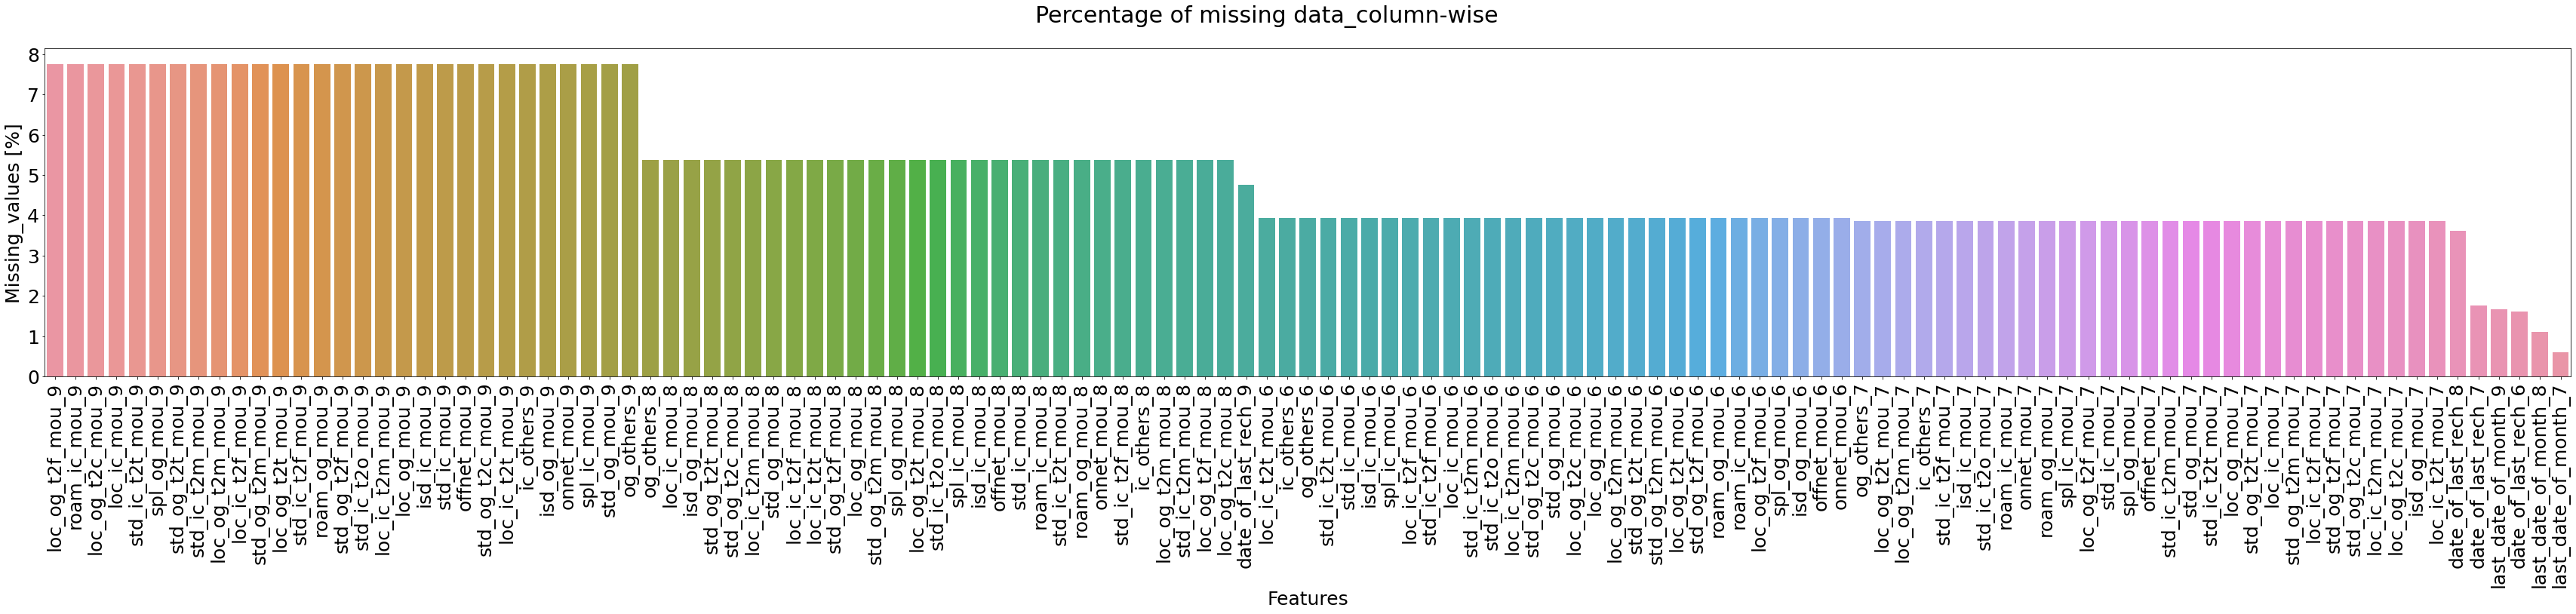

In [40]:
# plot the original data set missing values percentage 
# filter the missing values with 5%. for better visulization
df_fil_missing_col_perc_fil = df_fil_missing_col_perc.loc[df_fil_missing_col_perc['% of missing data']>0]

plt.figure(figsize = (60,8))
fig = sns.barplot(x = 'Features', y = '% of missing data', data = df_fil_missing_col_perc_fil)

plt.xticks(rotation=90)
plt.suptitle('Percentage of missing data_column-wise', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel('Missing_values [%]',fontsize = 25)
plt.xlabel('Features',fontsize = 25)
plt.show()

In [41]:
# from each month, 'Minutes of usage - voice calls' related columns having missing values

In [42]:
# list of columns from june month
lst_jun_cols = [s for s in df_fil.columns if re.search('(?:_6)',s)]

# check missing values from june month columns
df_fil[lst_jun_cols].isnull().sum().sort_values(ascending = False)

std_ic_t2f_mou_6        3937
std_og_mou_6            3937
ic_others_6             3937
isd_ic_mou_6            3937
spl_ic_mou_6            3937
std_ic_mou_6            3937
std_ic_t2o_mou_6        3937
std_ic_t2m_mou_6        3937
std_ic_t2t_mou_6        3937
loc_ic_mou_6            3937
loc_ic_t2f_mou_6        3937
loc_ic_t2m_mou_6        3937
og_others_6             3937
spl_og_mou_6            3937
isd_og_mou_6            3937
loc_ic_t2t_mou_6        3937
std_og_t2c_mou_6        3937
loc_og_t2f_mou_6        3937
onnet_mou_6             3937
offnet_mou_6            3937
roam_ic_mou_6           3937
std_og_t2f_mou_6        3937
loc_og_t2t_mou_6        3937
loc_og_t2m_mou_6        3937
roam_og_mou_6           3937
loc_og_t2c_mou_6        3937
loc_og_mou_6            3937
std_og_t2t_mou_6        3937
std_og_t2m_mou_6        3937
date_of_last_rech_6     1607
monthly_3g_6               0
sachet_2g_6                0
count_rech_3g_6            0
sachet_3g_6                0
monthly_2g_6  

In [43]:
# check all 'Minutes of usage - voice calls' columns having same number of missing value rows 
df_fil[lst_jun_cols].loc[df_fil['std_ic_t2f_mou_6'].isnull()].isnull().sum().sort_values(ascending = False)

std_ic_t2f_mou_6        3937
std_og_mou_6            3937
ic_others_6             3937
isd_ic_mou_6            3937
spl_ic_mou_6            3937
std_ic_mou_6            3937
std_ic_t2o_mou_6        3937
std_ic_t2m_mou_6        3937
std_ic_t2t_mou_6        3937
loc_ic_mou_6            3937
loc_ic_t2f_mou_6        3937
loc_ic_t2m_mou_6        3937
og_others_6             3937
spl_og_mou_6            3937
isd_og_mou_6            3937
loc_ic_t2t_mou_6        3937
std_og_t2c_mou_6        3937
loc_og_t2f_mou_6        3937
onnet_mou_6             3937
offnet_mou_6            3937
roam_ic_mou_6           3937
std_og_t2f_mou_6        3937
loc_og_t2t_mou_6        3937
loc_og_t2m_mou_6        3937
roam_og_mou_6           3937
loc_og_t2c_mou_6        3937
loc_og_mou_6            3937
std_og_t2t_mou_6        3937
std_og_t2m_mou_6        3937
date_of_last_rech_6      774
monthly_3g_6               0
sachet_2g_6                0
count_rech_3g_6            0
sachet_3g_6                0
monthly_2g_6  

In [44]:
# check the 'total_og_mou_6','total_ic_mou_6' columns of missing value rows. 
df_fil[['total_og_mou_6','total_ic_mou_6']].loc[df_fil['std_ic_t2f_mou_6'].isnull()].describe()

# There is no outgoing or incoming 'Minutes of usage - voice calls', so we can impute zeros to missing values of mou.

,total_og_mou_6,total_ic_mou_6
count,3937.0,3937.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [45]:
# list of columns from july month
lst_jul_cols = [s for s in df_fil.columns if re.search('(?:_7)',s)]

# check missing values from july month columns
df_fil[lst_jul_cols].isnull().sum().sort_values(ascending = False)

std_ic_t2f_mou_7        3859
spl_ic_mou_7            3859
std_ic_mou_7            3859
std_ic_t2o_mou_7        3859
ic_others_7             3859
std_ic_t2m_mou_7        3859
std_ic_t2t_mou_7        3859
loc_ic_mou_7            3859
loc_ic_t2f_mou_7        3859
loc_ic_t2m_mou_7        3859
loc_ic_t2t_mou_7        3859
og_others_7             3859
spl_og_mou_7            3859
isd_og_mou_7            3859
std_og_mou_7            3859
std_og_t2c_mou_7        3859
std_og_t2f_mou_7        3859
std_og_t2m_mou_7        3859
std_og_t2t_mou_7        3859
loc_og_mou_7            3859
loc_og_t2c_mou_7        3859
loc_og_t2f_mou_7        3859
loc_og_t2m_mou_7        3859
loc_og_t2t_mou_7        3859
roam_og_mou_7           3859
roam_ic_mou_7           3859
offnet_mou_7            3859
onnet_mou_7             3859
isd_ic_mou_7            3859
date_of_last_rech_7     1767
last_date_of_month_7     601
total_ic_mou_7             0
arpu_7                     0
sachet_3g_7                0
monthly_3g_7  

In [46]:
# check all 'Minutes of usage - voice calls' columns having same number of missing value rows 
df_fil[lst_jul_cols].loc[df_fil['std_ic_t2f_mou_7'].isnull()].isnull().sum().sort_values(ascending = False)

std_ic_t2f_mou_7        3859
spl_ic_mou_7            3859
std_ic_mou_7            3859
std_ic_t2o_mou_7        3859
ic_others_7             3859
std_ic_t2m_mou_7        3859
std_ic_t2t_mou_7        3859
loc_ic_mou_7            3859
loc_ic_t2f_mou_7        3859
loc_ic_t2m_mou_7        3859
loc_ic_t2t_mou_7        3859
og_others_7             3859
spl_og_mou_7            3859
isd_og_mou_7            3859
std_og_mou_7            3859
std_og_t2c_mou_7        3859
std_og_t2f_mou_7        3859
std_og_t2m_mou_7        3859
std_og_t2t_mou_7        3859
loc_og_mou_7            3859
loc_og_t2c_mou_7        3859
loc_og_t2f_mou_7        3859
loc_og_t2m_mou_7        3859
loc_og_t2t_mou_7        3859
roam_og_mou_7           3859
roam_ic_mou_7           3859
offnet_mou_7            3859
onnet_mou_7             3859
isd_ic_mou_7            3859
date_of_last_rech_7      949
last_date_of_month_7     601
total_ic_mou_7             0
arpu_7                     0
sachet_3g_7                0
monthly_3g_7  

In [47]:
# check the 'total_og_mou_7','total_ic_mou_7' columns of missing value rows. 
df_fil[['total_og_mou_7','total_ic_mou_7']].loc[df_fil['std_ic_t2f_mou_7'].isnull()].describe()

# There is no outgoing or incoming 'Minutes of usage - voice calls', so we can impute zeros to missing values of mou.

,total_og_mou_7,total_ic_mou_7
count,3859.0,3859.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [48]:
# list of columns from aug month
lst_aug_cols = [s for s in df_fil.columns if re.search('(?:_8)',s)]

# check missing values from aug month columns
df_fil[lst_aug_cols].isnull().sum().sort_values(ascending = False)

std_ic_t2f_mou_8        5378
spl_ic_mou_8            5378
std_ic_mou_8            5378
std_ic_t2o_mou_8        5378
ic_others_8             5378
std_ic_t2m_mou_8        5378
std_ic_t2t_mou_8        5378
loc_ic_mou_8            5378
loc_ic_t2f_mou_8        5378
loc_ic_t2m_mou_8        5378
loc_ic_t2t_mou_8        5378
og_others_8             5378
spl_og_mou_8            5378
isd_og_mou_8            5378
std_og_mou_8            5378
std_og_t2c_mou_8        5378
std_og_t2f_mou_8        5378
std_og_t2m_mou_8        5378
std_og_t2t_mou_8        5378
loc_og_mou_8            5378
loc_og_t2c_mou_8        5378
loc_og_t2f_mou_8        5378
loc_og_t2m_mou_8        5378
loc_og_t2t_mou_8        5378
roam_og_mou_8           5378
roam_ic_mou_8           5378
offnet_mou_8            5378
onnet_mou_8             5378
isd_ic_mou_8            5378
date_of_last_rech_8     3622
last_date_of_month_8    1100
total_ic_mou_8             0
arpu_8                     0
sachet_3g_8                0
monthly_3g_8  

In [49]:
# check all 'Minutes of usage - voice calls' columns having same number of missing value rows 
df_fil[lst_aug_cols].loc[df_fil['std_ic_t2f_mou_8'].isnull()].isnull().sum().sort_values(ascending = False)

std_ic_t2f_mou_8        5378
spl_ic_mou_8            5378
std_ic_mou_8            5378
std_ic_t2o_mou_8        5378
ic_others_8             5378
std_ic_t2m_mou_8        5378
std_ic_t2t_mou_8        5378
loc_ic_mou_8            5378
loc_ic_t2f_mou_8        5378
loc_ic_t2m_mou_8        5378
loc_ic_t2t_mou_8        5378
og_others_8             5378
spl_og_mou_8            5378
isd_og_mou_8            5378
std_og_mou_8            5378
std_og_t2c_mou_8        5378
std_og_t2f_mou_8        5378
std_og_t2m_mou_8        5378
std_og_t2t_mou_8        5378
loc_og_mou_8            5378
loc_og_t2c_mou_8        5378
loc_og_t2f_mou_8        5378
loc_og_t2m_mou_8        5378
loc_og_t2t_mou_8        5378
roam_og_mou_8           5378
roam_ic_mou_8           5378
offnet_mou_8            5378
onnet_mou_8             5378
isd_ic_mou_8            5378
date_of_last_rech_8     1981
last_date_of_month_8    1100
total_ic_mou_8             0
arpu_8                     0
sachet_3g_8                0
monthly_3g_8  

In [50]:
# check the 'total_og_mou_8','total_ic_mou_8' columns of missing value rows. 
df_fil[['total_og_mou_8','total_ic_mou_8']].loc[df_fil['std_ic_t2f_mou_8'].isnull()].describe()

# There is no outgoing or incoming 'Minutes of usage - voice calls', so we can impute zeros to missing values of mou.

,total_og_mou_8,total_ic_mou_8
count,5378.0,5378.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [51]:
# list of columns from sep month
lst_sep_cols = [s for s in df_fil.columns if re.search('(?:_9)',s)]

# check missing values from aug month columns
df_fil[lst_sep_cols].isnull().sum().sort_values(ascending = False)

std_ic_t2f_mou_9        7745
spl_ic_mou_9            7745
std_ic_mou_9            7745
std_ic_t2o_mou_9        7745
ic_others_9             7745
std_ic_t2m_mou_9        7745
std_ic_t2t_mou_9        7745
loc_ic_mou_9            7745
loc_ic_t2f_mou_9        7745
loc_ic_t2m_mou_9        7745
loc_ic_t2t_mou_9        7745
og_others_9             7745
spl_og_mou_9            7745
isd_og_mou_9            7745
std_og_mou_9            7745
std_og_t2c_mou_9        7745
std_og_t2f_mou_9        7745
std_og_t2m_mou_9        7745
std_og_t2t_mou_9        7745
loc_og_mou_9            7745
loc_og_t2c_mou_9        7745
loc_og_t2f_mou_9        7745
loc_og_t2m_mou_9        7745
loc_og_t2t_mou_9        7745
roam_og_mou_9           7745
roam_ic_mou_9           7745
offnet_mou_9            7745
onnet_mou_9             7745
isd_ic_mou_9            7745
date_of_last_rech_9     4760
last_date_of_month_9    1659
total_ic_mou_9             0
arpu_9                     0
sachet_3g_9                0
monthly_3g_9  

In [52]:
# check all 'Minutes of usage - voice calls' columns having same number of missing value rows 
df_fil[lst_sep_cols].loc[df_fil['std_ic_t2f_mou_9'].isnull()].isnull().sum().sort_values(ascending = False)

std_ic_t2f_mou_9        7745
spl_ic_mou_9            7745
std_ic_mou_9            7745
std_ic_t2o_mou_9        7745
ic_others_9             7745
std_ic_t2m_mou_9        7745
std_ic_t2t_mou_9        7745
loc_ic_mou_9            7745
loc_ic_t2f_mou_9        7745
loc_ic_t2m_mou_9        7745
loc_ic_t2t_mou_9        7745
og_others_9             7745
spl_og_mou_9            7745
isd_og_mou_9            7745
std_og_mou_9            7745
std_og_t2c_mou_9        7745
std_og_t2f_mou_9        7745
std_og_t2m_mou_9        7745
std_og_t2t_mou_9        7745
loc_og_mou_9            7745
loc_og_t2c_mou_9        7745
loc_og_t2f_mou_9        7745
loc_og_t2m_mou_9        7745
loc_og_t2t_mou_9        7745
roam_og_mou_9           7745
roam_ic_mou_9           7745
offnet_mou_9            7745
onnet_mou_9             7745
isd_ic_mou_9            7745
date_of_last_rech_9     2887
last_date_of_month_9    1659
total_ic_mou_9             0
arpu_9                     0
sachet_3g_9                0
monthly_3g_9  

In [53]:
# check the 'total_og_mou_9','total_ic_mou_9' columns of missing value rows. 
df_fil[['total_og_mou_9','total_ic_mou_9']].loc[df_fil['std_ic_t2f_mou_9'].isnull()].describe()

# There is no outgoing or incoming 'Minutes of usage - voice calls', so we can impute zeros to missing values of mou.

,total_og_mou_9,total_ic_mou_9
count,7745.0,7745.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [54]:
date_cols_lst = [s for s in df_fil.columns if re.search('(?:date)',s)]
date_cols_lst

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9']

In [55]:
# drop date columns
df_fil.drop(columns = date_cols_lst, inplace = True)

In [56]:
# all missing values are related to 'Minutes of usage - voice calls'. from the above analysis, 
# decided to impute missing values with Zero 
df_fil.fillna(0, inplace=True)

In [57]:
df_fil.isnull().sum().sort_values(ascending= False).head()

arpu_6              0
std_ic_t2o_mou_7    0
total_rech_amt_7    0
total_rech_amt_8    0
total_rech_amt_9    0
dtype: int64

## High value customers

In [58]:
# list of common columns other than respective month columns
com_col = [i for i in df_fil.columns if not(re.search('(?:_6|_7|_8|_9|jun_|jul_|aug_|sep_)',i))]
print(com_col)

['aon']


In [59]:
# list the columns related to good phase ( means from 6th & 7th month)
good_ph_col = [i for i in df_fil.columns if re.search('(?:_6|_7|jun_|jul_)',i)]
print(good_ph_col)

['arpu_6', 'arpu_7', 'onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_6', 'isd_og_mou_7', 'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6', 'og_others_7', 'total_og_mou_6', 'total_og_mou_7', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_mou_6', 'loc_ic_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_mou_6', 'std_ic

In [60]:
# list of churn phase columns from 9th month
churn_ph_col = [i for i in df_fil.columns if re.search('(?:_9|sep_)',i)]
print(churn_ph_col)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'sep_vbc_3g']


In [61]:
rech_cols = [s for s in df_fil[good_ph_col].columns if re.search('(?:_rech_)',s)]
df_fil[rech_cols].isnull().sum()

total_rech_num_6      0
total_rech_num_7      0
total_rech_amt_6      0
total_rech_amt_7      0
max_rech_amt_6        0
max_rech_amt_7        0
total_rech_data_6     0
total_rech_data_7     0
max_rech_data_6       0
max_rech_data_7       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_3g_6       0
count_rech_3g_7       0
av_rech_amt_data_6    0
av_rech_amt_data_7    0
dtype: int64

In [62]:
df_fil[rech_cols].head()

,total_rech_num_6,total_rech_num_7,total_rech_amt_6,total_rech_amt_7,max_rech_amt_6,max_rech_amt_7,total_rech_data_6,total_rech_data_7,max_rech_data_6,max_rech_data_7,count_rech_2g_6,count_rech_2g_7,count_rech_3g_6,count_rech_3g_7,av_rech_amt_data_6,av_rech_amt_data_7
0,4,3,362,252,252,252,1.0,1.0,252.0,252.0,0.0,0.0,1.0,1.0,252.0,252.0
1,4,9,74,384,44,154,0.0,1.0,0.0,154.0,0.0,1.0,0.0,0.0,0.0,154.0
2,5,4,168,315,86,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,11,230,310,60,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,6,196,350,56,110,1.0,0.0,56.0,0.0,1.0,0.0,0.0,0.0,56.0,0.0


In [63]:
# High value customers = average_recharge_amount >= 70th percentile_of_average_recharge_amount
# average_recharge_amount = (total_recharge_amount_july + total_recharge_amount_june)/2
# total_recharge_amount_june/july = total_recharge_amount + toal_recharge_amount_data

In [64]:
# total_recharge_amount_june/july = total_recharge_amount + toal_recharge_amount_data
total_recharge_amount_june = df_fil['total_rech_amt_6']+(df_fil['total_rech_data_6']*df_fil['av_rech_amt_data_6'])
total_recharge_amount_july = df_fil['total_rech_amt_7']+(df_fil['total_rech_data_7']*df_fil['av_rech_amt_data_7'])

In [65]:
# average_recharge_amount = (total_recharge_amount_july + total_recharge_amount_june)/2
df_fil['avg_rech_amt_good_ph'] = (total_recharge_amount_june+total_recharge_amount_july)/2

In [66]:
avg_rechamt_70th_perc = df_fil['avg_rech_amt_good_ph'].quantile(0.7)
print('70th percentile of the average recharge amount in the good phase: ',avg_rechamt_70th_perc)

70th percentile of the average recharge amount in the good phase:  478.0


In [67]:
# create data frame for high value customers: average recharge amount of good phase should be >= 70th percentile
df_high_value_cust = df_fil.loc[df_fil['avg_rech_amt_good_ph']>=avg_rechamt_70th_perc]

In [68]:
# drop the 'avg_rech_amt_good_ph' after filtering high value customers
df_high_value_cust.drop(columns = 'avg_rech_amt_good_ph', inplace = True)

In [69]:
df_high_value_cust.shape

(30001, 209)

In [70]:
# create new column, which will be used to label churns.
# sum of the incoming & outgoing voice calls, internet volume data (2g, 3g) 
df_high_value_cust['total_mou_and_vol_9'] = df_high_value_cust[['total_ic_mou_9','total_og_mou_9',
                                                              'vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1)

In [71]:
# defined churn: if there is no usage of voice calls and internet data then label as churn_user =1, else 0
df_high_value_cust['churn_user'] = df_high_value_cust.apply(lambda row:1 if (row.total_mou_and_vol_9==0) else 0, axis=1)

In [72]:
# list of churn phase columns from 9th month
churn_ph_col = [i for i in df_high_value_cust.columns if re.search('(?:_9|sep_)',i)]
print(churn_ph_col)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'sep_vbc_3g', 'total_mou_and_vol_9']


In [73]:
# after assign churn lables, delete columns which are related to 9th month (churn phase month)
df_clean = df_high_value_cust.drop(columns = churn_ph_col).copy()

In [74]:
# final data set after data cleaning
df_clean.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_user
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,5.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,4,3,2,362,252,252,252,252,252,252,252,252,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,1.0,1.0,1.0,968,30.40,0.00,101.20,1
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.0,0.0,0.0,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,802,57.74,19.38,18.74,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,

In [75]:
df_clean.shape

(30001, 158)

In [76]:
# checking unique values
check_unique_count = pd.DataFrame([len(df_clean[i].unique()) for i in df_clean.columns],df_clean.columns)
check_unique_count.columns = ['Unique_count']
check_unique_count.loc[check_unique_count['Unique_count']<2]

,Unique_count
std_og_t2c_mou_6,1
std_og_t2c_mou_7,1
std_og_t2c_mou_8,1
std_ic_t2o_mou_6,1
std_ic_t2o_mou_7,1
std_ic_t2o_mou_8,1


In [77]:
# 'std_og_t2c_mou_x' & 'std_ic_t2o_mou_x' we can delete , since there is only one unique value.
drop_col_lst = check_unique_count.loc[check_unique_count['Unique_count']<2].index.tolist()
print(drop_col_lst)

df_clean.drop(columns = drop_col_lst , inplace = True) # drop the columns listed in drop_col_lst

['std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


# EDA

In [78]:
list_of_columns_plot = df_clean.columns.tolist() # list of columns for plots
len(list_of_columns_plot)

152

In [79]:
# function for distribution plot. giving column name and dataframe, plot the distribution. 
# for example, dataframe having 'arpu_6','arpu_7'& 'arpu_8', so passing columns as 'arpu', this function returns all
# 3 columns distribution.

def distplot_(df_plot,x):
    col_plot = [s for s in df_plot.columns if re.search(x,s)]
    no_sub_plots = max(3,len(col_plot))
    fig, axis = plt.subplots(1,no_sub_plots, figsize = (15,4))
    count = 0
    for i in col_plot:
        ax = axis[count]
        sns.distplot(df_plot[i], ax = ax)
        count+=1
    fig.suptitle(x+'_distribution plot',fontsize=15,x =0.5, y=0.95)
    fig.subplots_adjust(wspace=0.3,hspace=0.5 ) # adjust spaces between subplots width and height

In [80]:
# function for bar plot. giving column name and dataframe, plot the bar plots. 
# for example, dataframe having 'arpu_6','arpu_7'& 'arpu_8', so passing columns as 'arpu', this function returns all
# 3 columns bar plot.

def barplot_(df_plot,x):
    col_plot = [s for s in df_plot.columns if re.search(x,s)]
    no_sub_plots = max(3,len(col_plot))
    fig, axis = plt.subplots(1,no_sub_plots, figsize = (15,4))
    count = 0
    for i in col_plot:
        ax = axis[count]
        sns.barplot(y = df_plot[i], x = df_plot['churn_user'], ax = ax)
        count+=1
    fig.suptitle(x+'_barplot with respect to churn_user',fontsize=15,x =0.5, y=0.95)
    fig.subplots_adjust(wspace=0.8,hspace=0.5 ) # adjust spaces between subplots width and height

In [81]:
remove_6_tag = [s.rstrip('_6') for s in list_of_columns_plot]
remove_7_tag = [s.rstrip('_7') for s in remove_6_tag]
remove_8_tag = [s.rstrip('_8') for s in remove_7_tag]

In [82]:
print(remove_8_tag)

['arpu', 'arpu', 'arpu', 'onnet_mou', 'onnet_mou', 'onnet_mou', 'offnet_mou', 'offnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_ic_mou', 'roam_ic_mou', 'roam_og_mou', 'roam_og_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2t_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2m_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2f_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_t2c_mou', 'loc_og_t2c_mou', 'loc_og_mou', 'loc_og_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2t_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2m_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'std_og_t2f_mou', 'std_og_t2f_mou', 'std_og_mou', 'std_og_mou', 'std_og_mou', 'isd_og_mou', 'isd_og_mou', 'isd_og_mou', 'spl_og_mou', 'spl_og_mou', 'spl_og_mou', 'og_others', 'og_others', 'og_others', 'total_og_mou', 'total_og_mou', 'total_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2t_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2m_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_t2f_mou', 'loc_ic_t2f_mou', 'loc_ic_m

In [83]:
# remove 'jun_vbc_3g','jul_vbc_3g','aug_vbc_3g' columns and add 'vbd_3g' as unique column for all 3 months
remove_cols_tags = [s for s in remove_8_tag if s not in['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']]
remove_cols_tags.append('vbc_3g')
len(remove_cols_tags)

150

In [84]:
# create unique list of columns from all 3 months
list_unique_col_plot = list(set(remove_cols_tags))
print(len(list_unique_col_plot))
print(list_unique_col_plot)

52
['offnet_mou', 'roam_ic_mou', 'std_og_mou', 'std_ic_t2m_mou', 'roam_og_mou', 'total_og_mou', 'loc_og_t2f_mou', 'std_ic_mou', 'night_pck_user', 'aon', 'loc_ic_mou', 'isd_og_mou', 'arpu_3g', 'og_others', 'monthly_3g', 'churn_user', 'max_rech_data', 'std_ic_t2f_mou', 'last_day_rch_amt', 'arpu', 'loc_ic_t2f_mou', 'vbc_3g', 'spl_ic_mou', 'count_rech_3g', 'onnet_mou', 'std_ic_t2t_mou', 'std_og_t2f_mou', 'count_rech_2g', 'std_og_t2t_mou', 'isd_ic_mou', 'max_rech_amt', 'loc_og_t2t_mou', 'loc_og_mou', 'monthly_2g', 'ic_others', 'loc_ic_t2m_mou', 'vol_2g_mb', 'loc_ic_t2t_mou', 'sachet_2g', 'av_rech_amt_data', 'vol_3g_mb', 'loc_og_t2c_mou', 'total_rech_num', 'total_rech_data', 'std_og_t2m_mou', 'fb_user', 'total_ic_mou', 'loc_og_t2m_mou', 'spl_og_mou', 'arpu_2g', 'total_rech_amt', 'sachet_3g']


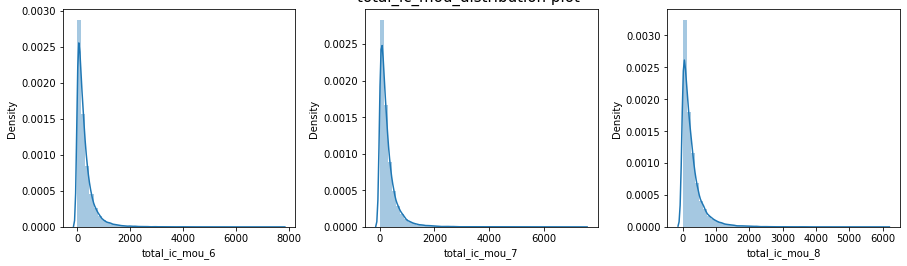

In [85]:
# total incoming calls distribution for first 3 months
distplot_(df_clean,'total_ic_mou')

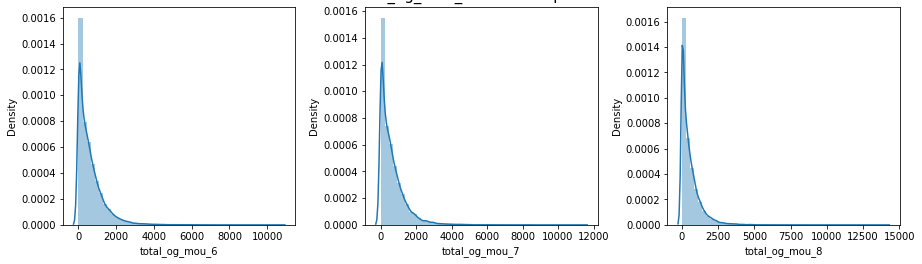

In [86]:
# total outgoing calls distribution for first 3 months
distplot_(df_clean,'total_og_mou')

***Distribution of incoming and out going data are having right skewed.***

### Check the unique values from the dataframe

In [87]:
check_unique_count.loc[((check_unique_count['Unique_count']>1)&(check_unique_count['Unique_count']<5))].index.tolist()

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'churn_user']

In [88]:
# all columns, having 2 unique values convert the data type as categorical variables
cat_col_lst = check_unique_count.loc[((check_unique_count['Unique_count']>1)&
                                      (check_unique_count['Unique_count']<5))].index.tolist()
print(cat_col_lst)

df_clean[cat_col_lst] = df_clean[cat_col_lst].astype('object') # change data type to object

['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'churn_user']


In [89]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Columns: 152 entries, arpu_6 to churn_user
dtypes: float64(120), int64(25), object(7)
memory usage: 35.0+ MB


In [90]:
# separate numerical and categorical columns to drive new columns from numerical columns
df_clean_cat = df_clean.select_dtypes(include = 'object').copy()
df_clean_num = df_clean.drop(columns = cat_col_lst) # remove categorical columns from the df_clean dataset

df_clean_cat.head()

,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,churn_user
0,0.0,0.0,0.0,1.0,1.0,1.0,1
7,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.0,0.0,0.0,0.0,1.0,1.0,0
21,0.0,0.0,0.0,0.0,0.0,0.0,0
23,0.0,0.0,0.0,0.0,1.0,1.0,0


In [91]:
df_clean_num.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,5.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,4,3,2,362,252,252,252,252,252,252,252,252,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.5,0.0,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.0,0.00,0.00,0.0,0.0,10.23,0.0,0.0,0.0,508.36,431.66,171.56,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,81.43,23.83,15.79,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,22.43,4.66,0.75,103.86,28.4

In [92]:
# create data frame with only columns from jun month
df_clean_jun = df_clean_num[[s for s in df_clean_num.columns if re.search('(?:_6|jun_)',s)]].copy()

# strip '_6' from column names
df_clean_jun.columns = [s.rstrip('_6') for s in df_clean_jun.columns]

# rename the specific column name
df_clean_jun.rename(columns={'jun_vbc_3g':'vbc_3g'}, inplace=True)

df_clean_jun.head()

,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,loc_og_mou,std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,std_og_mou,isd_og_mou,spl_og_mou,og_others,total_og_mou,loc_ic_t2t_mou,loc_ic_t2m_mou,loc_ic_t2f_mou,loc_ic_mou,std_ic_t2t_mou,std_ic_t2m_mou,std_ic_t2f_mou,std_ic_mou,total_ic_mou,spl_ic_mou,isd_ic_mou,ic_others,total_rech_num,total_rech_amt,max_rech_amt,last_day_rch_amt,total_rech_data,max_rech_data,count_rech_2g,count_rech_3g,av_rech_amt_data,vol_2g_mb,vol_3g_mb,arpu_3g,arpu_2g,monthly_2g,sachet_2g,monthly_3g,sachet_3g,vbc_3g
0,197.385,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4,362,252,252,1.0,252.0,0.0,1.0,252.0,30.13,83.57,212.17,212.17,0,0,1,0,101.20
7,1069.180,57.84,453.43,16.23,23.74,51.39,308.63,62.13,0.0,422.16,4.30,49.89,6.66,60.86,0.0,4.5,0.0,487.53,58.14,217.56,152.16,427.88,36.89,91.44,52.19,180.54,626.46,0.21,2.06,15.74,5,1580,1580,0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,18.74
8,378.721,413.69,94.66,0.00,0.00,297.13,80.96,0.00,0.0,378.09,116.56,13.69,0.00,130.26,0.0,0.0,0.0,508.36,23.84,57.58,0.00,81.43,0.00,22.43,0.00,22.43,103.86,0.00,0.00,0.00,19,437,90,50,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,122.16
21,514.453,102.41,757.93,0.00,0.00,4.48,91.81,0.75,0.0,97.04,97.93,665.36,0.00,763.29,0.0,0.0,0.0,860.34,2.48,118.23,4.61,125.33,14.06,67.69,0.00,81.76,207.09,0.00,0.00,0.00,22,600,50,30,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0.00
23,74.350,48.96,85.41,0.00,0.00,48.96,82.94,0.00,0.0,131.91,0.00,2.36,0.00,2.36,0.0,0.1,0.0,134.38,20.71,95.91,0.00,116.63,0.51,2.43,0.00,2.94,119.58,0.00,0.00,0.00,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0.00


In [93]:
# create data frame with only columns from jul month
df_clean_jul = df_clean_num[[s for s in df_clean_num.columns if re.search('(?:_7|jul_)',s)]].copy()

# strip '_7' from column names
df_clean_jul.columns = [s.rstrip('_7') for s in df_clean_jul.columns]

# rename the specific column name
df_clean_jul.rename(columns={'jul_vbc_3g':'vbc_3g'}, inplace=True)

df_clean_jul.head()

,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,loc_og_mou,std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,std_og_mou,isd_og_mou,spl_og_mou,og_others,total_og_mou,loc_ic_t2t_mou,loc_ic_t2m_mou,loc_ic_t2f_mou,loc_ic_mou,std_ic_t2t_mou,std_ic_t2m_mou,std_ic_t2f_mou,std_ic_mou,total_ic_mou,spl_ic_mou,isd_ic_mou,ic_others,total_rech_num,total_rech_amt,max_rech_amt,last_day_rch_amt,total_rech_data,max_rech_data,count_rech_2g,count_rech_3g,av_rech_amt_data,vol_2g_mb,vol_3g_mb,arpu_3g,arpu_2g,monthly_2g,sachet_2g,monthly_3g,sachet_3g,vbc_3g
0,214.816,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,3,252,252,252,1.0,252.0,0.0,1.0,252.0,1.32,150.76,212.17,212.17,0,0,1,0,0.00
7,1349.850,54.68,567.16,33.49,12.59,31.38,447.38,55.14,0.0,533.91,23.29,31.76,20.08,75.14,0.18,0.0,0.0,609.24,32.26,221.49,101.46,355.23,11.83,126.99,34.24,173.08,558.04,0.0,14.53,15.19,5,790,790,0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,19.38
8,492.223,351.03,80.63,0.00,0.00,217.59,70.58,0.00,0.0,288.18,133.43,10.04,0.00,143.48,0.00,0.0,0.0,431.66,9.84,13.98,0.00,23.83,0.58,4.08,0.00,4.66,28.49,0.0,0.00,0.00,21,601,154,0,2.0,154.0,2.0,0.0,177.0,356.00,750.95,0.00,0.00,1,1,0,0,910.65
21,597.753,132.11,896.68,0.00,0.00,6.16,87.93,0.00,0.0,94.09,125.94,808.74,0.00,934.69,0.00,0.0,0.0,1028.79,10.19,74.63,2.84,87.68,5.98,38.23,0.00,44.21,131.89,0.0,0.00,0.00,26,680,50,20,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0.00
23,193.897,50.66,89.36,0.00,0.00,50.66,83.01,0.00,0.0,133.68,0.00,6.35,0.00,6.35,0.01,0.0,0.0,140.04,61.04,113.36,0.00,174.41,0.00,14.89,0.00,14.89,222.89,0.0,28.23,5.35,5,454,179,179,2.0,179.0,0.0,2.0,356.0,0.48,599.09,306.57,301.78,0,0,2,0,51.86


In [94]:
# check both columns having same columns names
df_clean_jun.columns == df_clean_jul.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [95]:
lst_cols = df_clean_jun.columns.tolist() # back up of list of columns 

In [96]:
df_clean_jun.reset_index(inplace = True) # reset index
df_clean_jul.reset_index(inplace = True) # reset index

# average values of jun & jul month 
df_clean_good_ph = pd.concat([df_clean_jun, df_clean_jul]).groupby('index')[lst_cols].mean()
df_clean_good_ph.head()

,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,loc_og_mou,std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,std_og_mou,isd_og_mou,spl_og_mou,og_others,total_og_mou,loc_ic_t2t_mou,loc_ic_t2m_mou,loc_ic_t2f_mou,loc_ic_mou,std_ic_t2t_mou,std_ic_t2m_mou,std_ic_t2f_mou,std_ic_mou,total_ic_mou,spl_ic_mou,isd_ic_mou,ic_others,total_rech_num,total_rech_amt,max_rech_amt,last_day_rch_amt,total_rech_data,max_rech_data,count_rech_2g,count_rech_3g,av_rech_amt_data,vol_2g_mb,vol_3g_mb,arpu_3g,arpu_2g,monthly_2g,sachet_2g,monthly_3g,sachet_3g,vbc_3g
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,206.1005,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.5,307.0,252.0,252.0,1.0,252.0,0.0,1.0,252.0,15.725,117.165,212.170,212.17,0.0,0.0,1.0,0.0,50.600
7,1209.5150,56.26,510.295,24.86,18.165,41.385,378.005,58.635,0.0,478.035,13.795,40.825,13.37,68.000,0.090,2.25,0.0,548.385,45.200,219.525,126.810,391.555,24.360,109.215,43.215,176.810,592.250,0.105,8.295,15.465,5.0,1185.0,1185.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,19.060
8,435.4720,382.36,87.645,0.00,0.000,257.360,75.770,0.000,0.0,333.135,124.995,11.865,0.00,136.870,0.000,0.00,0.0,470.010,16.840,35.780,0.000,52.630,0.290,13.255,0.000,13.545,66.175,0.000,0.000,0.000,20.0,519.0,122.0,25.0,1.0,77.0,1.0,0.0,88.5,178.000,375.475,0.000,0.00,0.5,0.5,0.0,0.0,516.405
21,556.1030,117.26,827.305,0.00,0.000,5.320,89.870,0.375,0.0,95.565,111.935,737.050,0.00,848.990,0.000,0.00,0.0,944.565,6.335,96.430,3.725,106.505,10.020,52.960,0.000,62.985,169.490,0.000,0.000,0.000,24.0,640.0,50.0,25.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000
23,134.1235,49.81,87.385,0.00,0.000,49.810,82.975,0.000,0.0,132.795,0.000,4.355,0.00,4.355,0.005,0.05,0.0,137.210,40.875,104.635,0.000,145.520,0.255,8.660,0.000,8.915,171.235,0.000,14.115,2.675,4.0,227.0,89.5,89.5,1.0,89.5,0.0,1.0,178.0,0.240,299.545,153.285,150.89,0.0,0.0,1.0,0.0,25.930


In [97]:
# create data frame with only columns from aug month
df_clean_aug = df_clean_num[[s for s in df_clean_num.columns if re.search('(?:_8|aug_)',s)]].copy()

# strip '_8' from column names
df_clean_aug.columns = [s.rstrip('_8') for s in df_clean_aug.columns]

# rename the specific column name
df_clean_aug.rename(columns={'aug_vbc_3g':'vbc_3g'}, inplace=True)

df_clean_aug.head()

,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,loc_og_mou,std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,std_og_mou,isd_og_mou,spl_og_mou,og_others,total_og_mou,loc_ic_t2t_mou,loc_ic_t2m_mou,loc_ic_t2f_mou,loc_ic_mou,std_ic_t2t_mou,std_ic_t2m_mou,std_ic_t2f_mou,std_ic_mou,total_ic_mou,spl_ic_mou,isd_ic_mou,ic_others,total_rech_num,total_rech_amt,max_rech_amt,last_day_rch_amt,total_rech_data,max_rech_data,count_rech_2g,count_rech_3g,av_rech_amt_data,vol_2g_mb,vol_3g_mb,arpu_3g,arpu_2g,monthly_2g,sachet_2g,monthly_3g,sachet_3g,vbc_3g
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,5.44,0.0,0.00,0.00,2,252,252,252,1.0,252.0,0.0,1.0,252.0,5.75,109.61,212.17,212.17,0,0,1,0,30.40
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7,3638,1580,779,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,57.74
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14,120,30,10,3.0,23.0,3.0,0.0,69.0,0.03,11.94,19.83,0.00,0,3,0,0,21.03
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27,718,50,50,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0.00
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,298.33,0.0,3.74,13.06,4,439,179,0,2.0,179.0,0.0,2.0,270.0,0.01,1009.92,197.27,150.67,0,0,1,1,40.45


In [98]:
# create new dataframe with new derived features from the difference between good phase & critical phase data 
df_clean_derived = (df_clean_good_ph - df_clean_aug.values)
df_clean_derived.columns = [s+'_Diff' for s in df_clean_derived.columns]
df_clean_derived.head()

,arpu_Diff,onnet_mou_Diff,offnet_mou_Diff,roam_ic_mou_Diff,roam_og_mou_Diff,loc_og_t2t_mou_Diff,loc_og_t2m_mou_Diff,loc_og_t2f_mou_Diff,loc_og_t2c_mou_Diff,loc_og_mou_Diff,std_og_t2t_mou_Diff,std_og_t2m_mou_Diff,std_og_t2f_mou_Diff,std_og_mou_Diff,isd_og_mou_Diff,spl_og_mou_Diff,og_others_Diff,total_og_mou_Diff,loc_ic_t2t_mou_Diff,loc_ic_t2m_mou_Diff,loc_ic_t2f_mou_Diff,loc_ic_mou_Diff,std_ic_t2t_mou_Diff,std_ic_t2m_mou_Diff,std_ic_t2f_mou_Diff,std_ic_mou_Diff,total_ic_mou_Diff,spl_ic_mou_Diff,isd_ic_mou_Diff,ic_others_Diff,total_rech_num_Diff,total_rech_amt_Diff,max_rech_amt_Diff,last_day_rch_amt_Diff,total_rech_data_Diff,max_rech_data_Diff,count_rech_2g_Diff,count_rech_3g_Diff,av_rech_amt_data_Diff,vol_2g_mb_Diff,vol_3g_mb_Diff,arpu_3g_Diff,arpu_2g_Diff,monthly_2g_Diff,sachet_2g_Diff,monthly_3g_Diff,sachet_3g_Diff,vbc_3g_Diff
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-7.7025,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,0.000,-0.160,-4.130,-1.150,-5.440,0.000,0.000,0.000,0.000,-5.440,0.000,0.000,0.000,1.5,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.975,7.555,0.000,0.00,0.0,0.0,0.0,0.0,20.200
7,-1961.9650,3.97,184.385,-6.78,-19.895,1.105,215.725,5.405,0.00,222.245,1.785,-8.315,-3.31,-9.840,-9.920,-4.25,0.0,198.225,17.890,98.335,87.280,203.515,-6.030,-32.115,21.005,-17.130,163.510,0.105,-23.295,0.325,-2.0,-2453.0,-395.0,-779.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,-38.680
8,298.1100,347.28,-48.835,0.00,0.000,244.870,25.230,0.000,-7.15,270.095,102.415,-63.825,0.00,38.590,0.000,-10.23,0.0,298.450,16.530,20.300,0.000,36.840,0.190,12.605,0.000,12.795,49.635,0.000,0.000,0.000,6.0,399.0,92.0,15.0,-2.0,54.0,-2.0,0.0,19.5,177.970,363.535,-19.830,0.00,0.5,-2.5,0.0,0.0,495.375
21,-81.6570,32.12,-156.085,0.00,0.000,-18.020,-14.940,-1.205,0.00,-34.175,50.145,-139.940,0.00,-89.800,0.000,0.00,0.0,-123.975,-13.205,-32.730,-6.665,-52.605,9.840,-48.780,0.000,-38.945,-91.550,0.000,0.000,0.000,-3.0,-78.0,0.0,-25.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000
23,-232.8425,16.23,-118.505,0.00,0.000,16.230,-65.585,0.000,-17.71,-49.345,0.000,-35.255,0.00,-35.255,0.005,-17.66,0.0,-102.270,-35.765,-42.205,-0.710,-78.690,-13.125,-35.250,0.000,-48.375,-127.095,0.000,10.375,-10.385,0.0,-212.0,-89.5,89.5,-1.0,-89.5,0.0,-1.0,-92.0,0.230,-710.375,-43.985,0.22,0.0,0.0,0.0,-1.0,-14.520


In [99]:
df_critical_ph = df_clean_num[[s for s in df_clean_num.columns if re.search('(?:_8|aug_)',s)]].copy()
df_critical_ph.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,5.44,0.0,0.00,0.00,2,252,252,252,1.0,252.0,0.0,1.0,252.0,5.75,109.61,212.17,212.17,0,0,1,0,30.40
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7,3638,1580,779,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,57.74
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14,120,30,10,3.0,23.0,3.0,0.0,69.0,0.03,11.94,19.83,0.00,0,3,0,0,21.03
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27,718,50,50,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0.00
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,298.33,0.0,3.74,13.06,4,439,179,0,2.0,179.0,0.0,2.0,270.0,0.01,1009.92,197.27,150.67,0,0,1,1,40.45


In [100]:
df_clean_diff = pd.concat([df_critical_ph,df_clean_derived], axis=1)
df_clean_diff.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,arpu_Diff,onnet_mou_Diff,offnet_mou_Diff,roam_ic_mou_Diff,roam_og_mou_Diff,loc_og_t2t_mou_Diff,loc_og_t2m_mou_Diff,loc_og_t2f_mou_Diff,loc_og_t2c_mou_Diff,loc_og_mou_Diff,std_og_t2t_mou_Diff,std_og_t2m_mou_Diff,std_og_t2f_mou_Diff,std_og_mou_Diff,isd_og_mou_Diff,spl_og_mou_Diff,og_others_Diff,total_og_mou_Diff,loc_ic_t2t_mou_Diff,loc_ic_t2m_mou_Diff,loc_ic_t2f_mou_Diff,loc_ic_mou_Diff,std_ic_t2t_mou_Diff,std_ic_t2m_mou_Diff,std_ic_t2f_mou_Diff,std_ic_mou_Diff,total_ic_mou_Diff,spl_ic_mou_Diff,isd_ic_mou_Diff,ic_others_Diff,total_rech_num_Diff,total_rech_amt_Diff,max_rech_amt_Diff,last_day_rch_amt_Diff,total_rech_data_Diff,max_rech_data_Diff,count_rech_2g_Diff,count_rech_3g_Diff,av_rech_amt_data_Diff,vol_2g_mb_Diff,vol_3g_mb_Diff,arpu_3g_Diff,arpu_2g_Diff,monthly_2g_Diff,sachet_2g_Diff,monthly_3g_Diff,sachet_3g_Diff,vbc_3g_Diff
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,5.44,0.0,0.00,0.00,2,252,252,252,1.0,252.0,0.0,1.0,252.0,5.75,109.61,212.17,212.17,0,0,1,0,30.40,-7.7025,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,0.000,-0.160,-4.130,-1.150,-5.440,0.000,0.000,0.000,0.000,-5.440,0.000,0.000,0.000,1.5,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.975,7.555,0.000,0.00,0.0,0.0,0.0,0.0,20.200
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7,3638,1580,779,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,57.74,-1961.9650,3.97,184.385,-6.78,-19.895,1.105,215.725,5.405,0.00,222.245,1.785,-8.315,-3.31,-9.840,-9.920,-4.25,0.0,198.225,17.890,98.335,87.280,203.515,-6.030,-32.115,21.005,-17.130,163.510,0.105,-23.295,0.325,-2.0,-2453.0,-395.0,-779.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,-38.680
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14,120,30,10,3.0,23.0,3.0,0.0,69.0,0.03,11.94,19.83,0.00,0,3,0,0,21.03,298.1100,347.28,-48.835,0.00,0.000,244.870,25.230,0.000,-7.15,270.095,102.415,-63.825,0.00,38.590,0.000,-10.23,0.0,298.450,16.530,20.300,0.000,36.840,0.190,12.605,0.000,12.795,49.635,0.000,0.000,0.000,6.0,399.0,92.0,15.0,-2.0,54.0,-2.0,0.0,19.5,177.970,363.535,-19.830,0.00,0.5,-2.5,0.0,0.0,495.375
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27,718,50,50,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0.00,-81.6570,32.12,-156.085,0.00,0.000,-18.020,-14.940,-1.205,0.00,-34.175,50.145,-139.940,0.00,-89.800,0.000,0.00,0.0,-123.975,-13.205,-32.730,-6.665,-52.605,9.840,-48.780,0.000,-38.945,-91.550,0.000,0.000,0.000,-3.0,-78.0,0.0,-25.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,298.33,0.0,3.74,13.06,4,439,179,0,2.0,179.0,0.0,2.0,270.0,0.01,1009.92,197.27,150.67,0,0,1,1,40.45,-232.8425,16.23,-118.505,0.00,0.000,16.230,-65.585,0.000,-17.71,-49.345

In [101]:
# add remaining coolumns from categorical and also column 'aon' to final dataframe
df_clean_diff['aon'] = df_clean_num['aon']
df_clean_diff[cat_col_lst] = df_clean_cat[cat_col_lst]

In [102]:
df_clean_diff.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,arpu_Diff,onnet_mou_Diff,offnet_mou_Diff,roam_ic_mou_Diff,roam_og_mou_Diff,loc_og_t2t_mou_Diff,loc_og_t2m_mou_Diff,loc_og_t2f_mou_Diff,loc_og_t2c_mou_Diff,loc_og_mou_Diff,std_og_t2t_mou_Diff,std_og_t2m_mou_Diff,std_og_t2f_mou_Diff,std_og_mou_Diff,isd_og_mou_Diff,spl_og_mou_Diff,og_others_Diff,total_og_mou_Diff,loc_ic_t2t_mou_Diff,loc_ic_t2m_mou_Diff,loc_ic_t2f_mou_Diff,loc_ic_mou_Diff,std_ic_t2t_mou_Diff,std_ic_t2m_mou_Diff,std_ic_t2f_mou_Diff,std_ic_mou_Diff,total_ic_mou_Diff,spl_ic_mou_Diff,isd_ic_mou_Diff,ic_others_Diff,total_rech_num_Diff,total_rech_amt_Diff,max_rech_amt_Diff,last_day_rch_amt_Diff,total_rech_data_Diff,max_rech_data_Diff,count_rech_2g_Diff,count_rech_3g_Diff,av_rech_amt_data_Diff,vol_2g_mb_Diff,vol_3g_mb_Diff,arpu_3g_Diff,arpu_2g_Diff,monthly_2g_Diff,sachet_2g_Diff,monthly_3g_Diff,sachet_3g_Diff,vbc_3g_Diff,aon,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,churn_user
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,5.44,0.0,0.00,0.00,2,252,252,252,1.0,252.0,0.0,1.0,252.0,5.75,109.61,212.17,212.17,0,0,1,0,30.40,-7.7025,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,0.000,-0.160,-4.130,-1.150,-5.440,0.000,0.000,0.000,0.000,-5.440,0.000,0.000,0.000,1.5,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.975,7.555,0.000,0.00,0.0,0.0,0.0,0.0,20.200,968,0.0,0.0,0.0,1.0,1.0,1.0,1
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7,3638,1580,779,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,57.74,-1961.9650,3.97,184.385,-6.78,-19.895,1.105,215.725,5.405,0.00,222.245,1.785,-8.315,-3.31,-9.840,-9.920,-4.25,0.0,198.225,17.890,98.335,87.280,203.515,-6.030,-32.115,21.005,-17.130,163.510,0.105,-23.295,0.325,-2.0,-2453.0,-395.0,-779.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,-38.680,802,0.0,0.0,0.0,0.0,0.0,0.0,1
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14,120,30,10,3.0,23.0,3.0,0.0,69.0,0.03,11.94,19.83,0.00,0,3,0,0,21.03,298.1100,347.28,-48.835,0.00,0.000,244.870,25.230,0.000,-7.15,270.095,102.415,-63.825,0.00,38.590,0.000,-10.23,0.0,298.450,16.530,20.300,0.000,36.840,0.190,12.605,0.000,12.795,49.635,0.000,0.000,0.000,6.0,399.0,92.0,15.0,-2.0,54.0,-2.0,0.0,19.5,177.970,363.535,-19.830,0.00,0.5,-2.5,0.0,0.0,495.375,315,0.0,0.0,0.0,0.0,1.0,1.0,0
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27,718,50,50,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0.00,-81.6570,32.12,-156.085,0.00,0.000,-18.020,-14.940,-1.205,0.00,-34.175,50.145,-139.940,0.00,-89.800,0.000,0.00,0.0,-123.975,-13.205,-32.730,-6.665,-52.605,9.840,-48.780,0.000,-38.945,-91.550,0.000,0.000,0.000,-3.0,-78.0,0.0,-25.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000,720,0.0,0.0,0.0,0.0,0.0,0.0,0
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76

In [103]:
df_clean_diff.shape

(30001, 104)

In [104]:
# derive features from categorical variables: 
# 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8'
# for example following derived feature from fb_user. and Similarly for night_pck_user

| <font color ='blue'>fb_user_6</font> | <font color ='blue'>fb_user_7</font> | <font color ='blue'>fb_user_8</font> |<font color ='blue'>derived_fb_user</font> |<font color ='blue'>description</font> |
| --- | --- | --- | --- | --- |
|0|0|0|0|Not a fb_user|
|0|0|1|1|Became a fb_user since from last/latest month| 
|0|1|0|-1|Not a active fb_user in the last/latest month|
|0|1|1|2|Active fb_user since from last/latest two months|
|1|0|0|-2|Not a active fb_user since from last/latest two months|
|1|0|1|1|Active fb_user in the last/latest month|
|1|1|0|-1|Not a active fb_user in the last/latest month|
|1|1|1|3|Active fb_user for all 3 months|

In [105]:
# change cetrogorical columns data type to int64
df_clean_diff[cat_col_lst] = df_clean_diff[cat_col_lst].astype('int64')

In [106]:
# create dictionary as per the above mentioned binary code table
bin_code_dict = dict({'000':0,'001':1,'010':-1,'011':2,'100':-2,'101':1,'110':-1,'111':3})
bin_code_dict

{'000': 0,
 '001': 1,
 '010': -1,
 '011': 2,
 '100': -2,
 '101': 1,
 '110': -1,
 '111': 3}

In [107]:
# list the fb_user_columns
fb_cols_lst = ['fb_user_6', 'fb_user_7', 'fb_user_8']

In [108]:
# concatenate the values from fb_user columns
df_clean_diff['derived_fb_user'] = df_clean_diff[fb_cols_lst].apply(lambda row: ''.join((row.values).astype(str)), axis=1)
df_clean_diff['derived_fb_user'].head()

0     111
7     000
8     011
21    000
23    011
Name: derived_fb_user, dtype: object

In [109]:
# assign the desired values to the binary code using 'bin_code_dict' dictionary
df_clean_diff['derived_fb_user'] = df_clean_diff['derived_fb_user'].apply(lambda X : bin_code_dict[X])
df_clean_diff['derived_fb_user'].head()

0     3
7     0
8     2
21    0
23    2
Name: derived_fb_user, dtype: int64

In [110]:
# list the night_pack_user_columns
ngt_pak_cols_lst = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8']

In [111]:
# concatenate the values from night_pack_user columns
df_clean_diff['derived_night_pck_user'] = df_clean_diff[ngt_pak_cols_lst].apply(lambda 
                                                                                row: ''.join((row.values).astype(str)), axis=1)
df_clean_diff['derived_night_pck_user'].head(10)

0     000
7     000
8     000
21    000
23    000
33    110
38    000
41    000
48    000
53    000
Name: derived_night_pck_user, dtype: object

In [112]:
# assign the desired values to the binary code using 'bin_code_dict' dictionary
df_clean_diff['derived_night_pck_user'] = df_clean_diff['derived_night_pck_user'].apply(lambda X : bin_code_dict[X])
df_clean_diff['derived_night_pck_user'].head(10)

0     0
7     0
8     0
21    0
23    0
33   -1
38    0
41    0
48    0
53    0
Name: derived_night_pck_user, dtype: int64

In [113]:
# drop the list of columns : 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8'
drop_cat_cols_lst = ['night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']
df_clean_diff.drop(columns = drop_cat_cols_lst, inplace = True)

In [114]:
# check count of unique values from derived column
df_clean_diff['derived_fb_user'].value_counts()

 0    11265
 3    11242
-1     2992
 1     1583
 2     1488
-2     1431
Name: derived_fb_user, dtype: int64

In [115]:
# check the churn_users count, with respect to 'derived_fb_user' value not equal to 0
df_clean_diff.loc[abs(df_clean_diff['derived_fb_user'])>0]['churn_user'].sum()

# 1243 churn_user are there when fb_user state not equal to 0, which is considerable % of churn_users from the data frame.

1243

In [116]:
# check count of unique values from derived column
df_clean_diff['derived_night_pck_user'].value_counts()

 0    29295
-2      187
-1      178
 1      144
 3      127
 2       70
Name: derived_night_pck_user, dtype: int64

In [117]:
# looks this columns details not much useful for predicting churn_users.
# lets check the number of churn_users with respect to 'derived_night_pck_user' value > 0
df_clean_diff.loc[abs(df_clean_diff['derived_night_pck_user'])>0]['churn_user'].sum()

# only 51 churn_user are there when night_pack_user state not equal to 0, 
# which is about little % of churn_users from the data frame. this columns looks not much useful to consider for modeling.
# so decided to drop this column.

51

In [118]:
# from the above details, decided to drop the columns.
df_clean_diff.drop(columns = 'derived_night_pck_user', inplace = True)

In [119]:
df_clean_diff.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,arpu_Diff,onnet_mou_Diff,offnet_mou_Diff,roam_ic_mou_Diff,roam_og_mou_Diff,loc_og_t2t_mou_Diff,loc_og_t2m_mou_Diff,loc_og_t2f_mou_Diff,loc_og_t2c_mou_Diff,loc_og_mou_Diff,std_og_t2t_mou_Diff,std_og_t2m_mou_Diff,std_og_t2f_mou_Diff,std_og_mou_Diff,isd_og_mou_Diff,spl_og_mou_Diff,og_others_Diff,total_og_mou_Diff,loc_ic_t2t_mou_Diff,loc_ic_t2m_mou_Diff,loc_ic_t2f_mou_Diff,loc_ic_mou_Diff,std_ic_t2t_mou_Diff,std_ic_t2m_mou_Diff,std_ic_t2f_mou_Diff,std_ic_mou_Diff,total_ic_mou_Diff,spl_ic_mou_Diff,isd_ic_mou_Diff,ic_others_Diff,total_rech_num_Diff,total_rech_amt_Diff,max_rech_amt_Diff,last_day_rch_amt_Diff,total_rech_data_Diff,max_rech_data_Diff,count_rech_2g_Diff,count_rech_3g_Diff,av_rech_amt_data_Diff,vol_2g_mb_Diff,vol_3g_mb_Diff,arpu_3g_Diff,arpu_2g_Diff,monthly_2g_Diff,sachet_2g_Diff,monthly_3g_Diff,sachet_3g_Diff,vbc_3g_Diff,aon,churn_user,derived_fb_user
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,5.44,0.0,0.00,0.00,2,252,252,252,1.0,252.0,0.0,1.0,252.0,5.75,109.61,212.17,212.17,0,0,1,0,30.40,-7.7025,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,0.000,-0.160,-4.130,-1.150,-5.440,0.000,0.000,0.000,0.000,-5.440,0.000,0.000,0.000,1.5,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.975,7.555,0.000,0.00,0.0,0.0,0.0,0.0,20.200,968,1,3
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7,3638,1580,779,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,57.74,-1961.9650,3.97,184.385,-6.78,-19.895,1.105,215.725,5.405,0.00,222.245,1.785,-8.315,-3.31,-9.840,-9.920,-4.25,0.0,198.225,17.890,98.335,87.280,203.515,-6.030,-32.115,21.005,-17.130,163.510,0.105,-23.295,0.325,-2.0,-2453.0,-395.0,-779.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,-38.680,802,1,0
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14,120,30,10,3.0,23.0,3.0,0.0,69.0,0.03,11.94,19.83,0.00,0,3,0,0,21.03,298.1100,347.28,-48.835,0.00,0.000,244.870,25.230,0.000,-7.15,270.095,102.415,-63.825,0.00,38.590,0.000,-10.23,0.0,298.450,16.530,20.300,0.000,36.840,0.190,12.605,0.000,12.795,49.635,0.000,0.000,0.000,6.0,399.0,92.0,15.0,-2.0,54.0,-2.0,0.0,19.5,177.970,363.535,-19.830,0.00,0.5,-2.5,0.0,0.0,495.375,315,0,2
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27,718,50,50,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0.00,-81.6570,32.12,-156.085,0.00,0.000,-18.020,-14.940,-1.205,0.00,-34.175,50.145,-139.940,0.00,-89.800,0.000,0.00,0.0,-123.975,-13.205,-32.730,-6.665,-52.605,9.840,-48.780,0.000,-38.945,-91.550,0.000,0.000,0.000,-3.0,-78.0,0.0,-25.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000,720,0,0
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,298.33,0.0,3.74,13.06,4,439,179,0,2.0,179.0,0.0,2.0,270.0,0.01,1009.92,197.27,150.67,0,0,1,1,40.45,-232.842

In [120]:
# set the target column at the end
lst = df_clean_diff.columns.tolist()
lst.remove('churn_user')
lst.append('churn_user')
df_cleaned = df_clean_diff[lst].copy()

df_cleaned.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,arpu_Diff,onnet_mou_Diff,offnet_mou_Diff,roam_ic_mou_Diff,roam_og_mou_Diff,loc_og_t2t_mou_Diff,loc_og_t2m_mou_Diff,loc_og_t2f_mou_Diff,loc_og_t2c_mou_Diff,loc_og_mou_Diff,std_og_t2t_mou_Diff,std_og_t2m_mou_Diff,std_og_t2f_mou_Diff,std_og_mou_Diff,isd_og_mou_Diff,spl_og_mou_Diff,og_others_Diff,total_og_mou_Diff,loc_ic_t2t_mou_Diff,loc_ic_t2m_mou_Diff,loc_ic_t2f_mou_Diff,loc_ic_mou_Diff,std_ic_t2t_mou_Diff,std_ic_t2m_mou_Diff,std_ic_t2f_mou_Diff,std_ic_mou_Diff,total_ic_mou_Diff,spl_ic_mou_Diff,isd_ic_mou_Diff,ic_others_Diff,total_rech_num_Diff,total_rech_amt_Diff,max_rech_amt_Diff,last_day_rch_amt_Diff,total_rech_data_Diff,max_rech_data_Diff,count_rech_2g_Diff,count_rech_3g_Diff,av_rech_amt_data_Diff,vol_2g_mb_Diff,vol_3g_mb_Diff,arpu_3g_Diff,arpu_2g_Diff,monthly_2g_Diff,sachet_2g_Diff,monthly_3g_Diff,sachet_3g_Diff,vbc_3g_Diff,aon,derived_fb_user,churn_user
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,5.44,0.0,0.00,0.00,2,252,252,252,1.0,252.0,0.0,1.0,252.0,5.75,109.61,212.17,212.17,0,0,1,0,30.40,-7.7025,0.00,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.0,0.000,-0.160,-4.130,-1.150,-5.440,0.000,0.000,0.000,0.000,-5.440,0.000,0.000,0.000,1.5,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.975,7.555,0.000,0.00,0.0,0.0,0.0,0.0,20.200,968,3,1
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7,3638,1580,779,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,57.74,-1961.9650,3.97,184.385,-6.78,-19.895,1.105,215.725,5.405,0.00,222.245,1.785,-8.315,-3.31,-9.840,-9.920,-4.25,0.0,198.225,17.890,98.335,87.280,203.515,-6.030,-32.115,21.005,-17.130,163.510,0.105,-23.295,0.325,-2.0,-2453.0,-395.0,-779.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,-38.680,802,0,1
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14,120,30,10,3.0,23.0,3.0,0.0,69.0,0.03,11.94,19.83,0.00,0,3,0,0,21.03,298.1100,347.28,-48.835,0.00,0.000,244.870,25.230,0.000,-7.15,270.095,102.415,-63.825,0.00,38.590,0.000,-10.23,0.0,298.450,16.530,20.300,0.000,36.840,0.190,12.605,0.000,12.795,49.635,0.000,0.000,0.000,6.0,399.0,92.0,15.0,-2.0,54.0,-2.0,0.0,19.5,177.970,363.535,-19.830,0.00,0.5,-2.5,0.0,0.0,495.375,315,2,0
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27,718,50,50,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0,0,0,0,0.00,-81.6570,32.12,-156.085,0.00,0.000,-18.020,-14.940,-1.205,0.00,-34.175,50.145,-139.940,0.00,-89.800,0.000,0.00,0.0,-123.975,-13.205,-32.730,-6.665,-52.605,9.840,-48.780,0.000,-38.945,-91.550,0.000,0.000,0.000,-3.0,-78.0,0.0,-25.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.000,720,0,0
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,298.33,0.0,3.74,13.06,4,439,179,0,2.0,179.0,0.0,2.0,270.0,0.01,1009.92,197.27,150.67,0,0,1,1,40.45,-232.842

In [121]:
# check the dataframe describe ( include 1% and 99% to compare with min and max values of the respective columns)
df_cleaned.describe(percentiles = [0.01,0.99])

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,arpu_Diff,onnet_mou_Diff,offnet_mou_Diff,roam_ic_mou_Diff,roam_og_mou_Diff,loc_og_t2t_mou_Diff,loc_og_t2m_mou_Diff,loc_og_t2f_mou_Diff,loc_og_t2c_mou_Diff,loc_og_mou_Diff,std_og_t2t_mou_Diff,std_og_t2m_mou_Diff,std_og_t2f_mou_Diff,std_og_mou_Diff,isd_og_mou_Diff,spl_og_mou_Diff,og_others_Diff,total_og_mou_Diff,loc_ic_t2t_mou_Diff,loc_ic_t2m_mou_Diff,loc_ic_t2f_mou_Diff,loc_ic_mou_Diff,std_ic_t2t_mou_Diff,std_ic_t2m_mou_Diff,std_ic_t2f_mou_Diff,std_ic_mou_Diff,total_ic_mou_Diff,spl_ic_mou_Diff,isd_ic_mou_Diff,ic_others_Diff,total_rech_num_Diff,total_rech_amt_Diff,max_rech_amt_Diff,last_day_rch_amt_Diff,total_rech_data_Diff,max_rech_data_Diff,count_rech_2g_Diff,count_rech_3g_Diff,av_rech_amt_data_Diff,vol_2g_mb_Diff,vol_3g_mb_Diff,arpu_3g_Diff,arpu_2g_Diff,monthly_2g_Diff,sachet_2g_Diff,monthly_3g_Diff,sachet_3g_Diff,vbc_3g_Diff,aon,derived_fb_user,churn_user
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,508.597957,234.112539,335.077044,12.500551,19.865615,78.077112,151.756812,5.886385,1.707746,235.728174,148.441175,157.350068,1.584734,307.379315,1.948970,6.557204,0.057607,551.678812,62.619432,146.232731,14.403175,223.264679,13.913705,27.922597,2.561970,44.401653,279.922931,0.026567,10.998257,1.224455,9.972868,584.365454,160.144462,92.393654,1.621913,72.492917,1.208493,0.413420,122.132258,105.913072,351.493998,62.773480,58.395301,0.153628,1.054865,0.211026,0.202393,169.138860,51.038557,30.193620,40.821520,1.875878,3.496201,7.002408,11.369818,0.497514,0.024744,18.870166,21.618459,26.327010,0.230066,48.175917,0.189665,-0.093746,0.294391,67.437337,3.425675,4.786070,1.253842,9.465915,1.244436,2.086269,0.185179,3.516120,13.430810,0.013833,0.331985,0.102438,1.812056,76.249725,10.598813,8.231159,0.138845,6.467768,0.110430,0.028416,13.085795,19.896683,5.733637,5.041000,5.675100,0.025249,0.085180,0.012366,0.016049,-0.440497,1209.368754,1.080997,0.081364
std,501.961981,458.448598,482.062509,74.125281,104.719009,227.373609,233.660905,19.502281,7.208138,363.370172,397.564547,409.100284,10.931804,608.976504,44.712024,20.311857,3.

In [122]:
df_cleaned.shape

(30001, 99)

***There are outliers in the data set, for example,`'offnet_mou_8'` max values is 14007.34 and 99% values is 2193.13 minutes which is realistic. So decided to perform outliers removal using statistical method*** 

In [123]:
#defined function for filter outliers -- # removing (statistical) outliers
def filter_OutLiers(df,column_name):
    Q1 = df[column_name].quantile(0.02)
    Q3 = df[column_name].quantile(0.98)
    IQR = Q3 - Q1
    df_temp = df.loc[((df[column_name] >= (Q1 - 1.5 * IQR)) & (df[column_name] <= (Q3 + 1.5 * IQR)))]
    return(df_temp)

In [124]:
df_outliers = df_cleaned.copy()

In [125]:
for i in df_outliers.columns:
    df_outliers = filter_OutLiers(df_outliers,i).copy()

In [126]:
df_outliers.shape

(24819, 99)

In [127]:
# check the deleted rows to understand how much churns in the rows
lst_index = df_cleaned.index.tolist()
deleted_rows_list = [x for x in lst_index if x not in df_outliers.index.tolist()]

In [128]:
len(deleted_rows_list) # number of rows dropped

5182

In [129]:
df_deleted_rows = df_cleaned[df_cleaned.index.isin(deleted_rows_list)].copy()
df_deleted_rows.churn_user.value_counts()

0    4722
1     460
Name: churn_user, dtype: int64

***Out of 5182 rows , 460 rows from churn_users. it is about 11% of the total deleted rows.***

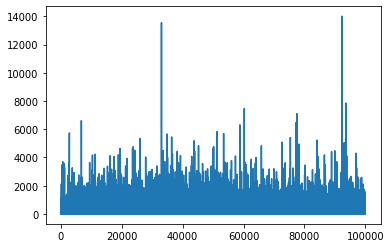

In [130]:
# before outliers plot for 'offnet_mou_8'
df_cleaned['offnet_mou_8'].plot();plt.show()

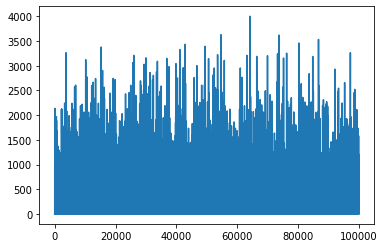

In [131]:
# after outliers plot for 'offnet_mou_8'
df_outliers['offnet_mou_8'].plot();plt.show()

In [132]:
df_outliers.describe(percentiles = [0.01,0.99])

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,arpu_2g_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aug_vbc_3g,arpu_Diff,onnet_mou_Diff,offnet_mou_Diff,roam_ic_mou_Diff,roam_og_mou_Diff,loc_og_t2t_mou_Diff,loc_og_t2m_mou_Diff,loc_og_t2f_mou_Diff,loc_og_t2c_mou_Diff,loc_og_mou_Diff,std_og_t2t_mou_Diff,std_og_t2m_mou_Diff,std_og_t2f_mou_Diff,std_og_mou_Diff,isd_og_mou_Diff,spl_og_mou_Diff,og_others_Diff,total_og_mou_Diff,loc_ic_t2t_mou_Diff,loc_ic_t2m_mou_Diff,loc_ic_t2f_mou_Diff,loc_ic_mou_Diff,std_ic_t2t_mou_Diff,std_ic_t2m_mou_Diff,std_ic_t2f_mou_Diff,std_ic_mou_Diff,total_ic_mou_Diff,spl_ic_mou_Diff,isd_ic_mou_Diff,ic_others_Diff,total_rech_num_Diff,total_rech_amt_Diff,max_rech_amt_Diff,last_day_rch_amt_Diff,total_rech_data_Diff,max_rech_data_Diff,count_rech_2g_Diff,count_rech_3g_Diff,av_rech_amt_data_Diff,vol_2g_mb_Diff,vol_3g_mb_Diff,arpu_3g_Diff,arpu_2g_Diff,monthly_2g_Diff,sachet_2g_Diff,monthly_3g_Diff,sachet_3g_Diff,vbc_3g_Diff,aon,derived_fb_user,churn_user
count,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.0,24819.000000,24819.000000,24819.000000,24819.00000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000
mean,451.173344,212.264694,305.305657,6.937003,12.129068,62.122742,141.796506,4.526831,1.374375,208.453800,145.268885,147.445613,0.661165,293.378865,0.051282,5.245037,0.0,507.136227,50.136555,133.944121,11.32164,195.411576,8.435205,19.355458,1.262859,29.056704,228.693174,0.027386,3.715428,0.475131,9.653572,517.738426,142.930739,82.099198,1.548894,67.553648,1.228212,0.320682,111.152544,98.944149,291.293322,50.268307,47.481201,0.151336,1.076877,0.186994,0.133688,149.995039,58.992165,33.534450,46.219654,2.433665,4.633875,6.439636,11.515943,0.461001,0.101912,18.416985,25.248527,30.672885,0.156501,56.078319,0.050646,0.296973,0.291371,75.135282,3.819256,5.042747,1.073997,9.936346,1.218902,2.298733,0.191187,3.709076,14.146395,0.011748,0.368822,0.119862,1.890910,83.370361,11.255208,9.834804,0.194367,7.680749,0.140356,0.054011,16.459254,24.448977,18.533213,7.251685,7.812606,0.028567,0.111789,0.016379,0.037632,3.358307,1199.656835,1.079173,0.079818
std,329.157923,377.491997,398.939373,29.510743,47.817884,121.485984,206.358729,11.939367,4.308020,278.518792,357.716348,338.863829,3.159558,528.319624,0.447682,10.732874,0.0,587.597889,82.0773

In [133]:
df_prep = df_outliers.copy() # create new dataframe as prepared dataframe

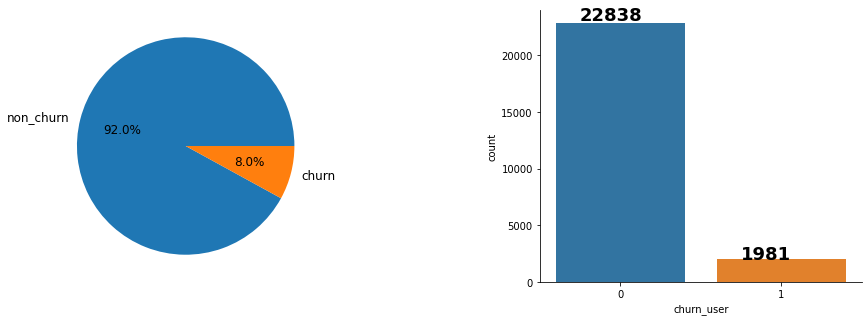

In [134]:
# check data imbalance

fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
fig.suptitle('Target Variable details',fontsize=15, y=1.0)
ax = axes[0]
ax.pie(df_prep['churn_user'].value_counts(), labels= ['non_churn', 'churn'], 
       autopct = '%1.1f%%',textprops={'size': 'large'}) 

fig1 = sns.countplot(x = 'churn_user', data = df_prep)
sns.despine(top=True, right=True, left=False, bottom=False)
for p in fig1.patches:
    
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    fig1.annotate('{:.0f}'.format(height), (x+0.15, y + height*1.01),fontsize=18,weight='bold')
fig.subplots_adjust(wspace=0.6)
plt.show()

In [135]:
# need to take care about data imbalance in next steps before proceeding with modeling

In [136]:
df_prep = df_prep.astype('float64')

In [137]:
#df_prep.to_csv('data/df_prep.csv')

In [140]:
y = df_prep['churn_user']
X = df_prep.drop(columns='churn_user', axis=1)

In [141]:
# split the data in to train and test data sets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

### Apply Logistic regression (With PCA)

In [139]:
pca_pipe = Pipeline([('scaler',StandardScaler()),('pca',PCA(random_state = 42))]) # creat object

In [140]:
pca_pipe.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(random_state=42))])

In [141]:
#List of PCA components
pca_pipe.named_steps.pca.components_

array([[ 2.24962880e-01,  1.03283072e-01,  1.44054244e-01, ...,
        -5.57690278e-02,  4.17129900e-02,  8.14640268e-02],
       [-6.74222903e-02, -1.44630549e-01, -1.54896235e-01, ...,
        -7.65979861e-02,  3.04659001e-03,  1.98578197e-01],
       [-7.13809978e-02,  5.47104241e-02, -4.10553678e-02, ...,
        -1.66808985e-03, -1.34123125e-01,  7.06030564e-02],
       ...,
       [-0.00000000e+00,  7.44056051e-16,  7.40187988e-16, ...,
         2.77555756e-17,  4.16333634e-17,  7.63278329e-17],
       [ 0.00000000e+00,  5.49094020e-15,  7.13311860e-15, ...,
         3.46944695e-17, -6.63531730e-17, -2.24213009e-16],
       [ 0.00000000e+00,  4.55230610e-15,  3.81240617e-15, ...,
         1.59594560e-16,  1.24900090e-16, -2.77555756e-17]])

In [142]:
#Let's check the variance ratios
pca_pipe.named_steps.pca.explained_variance_ratio_

array([1.21734728e-01, 8.30489253e-02, 5.43144964e-02, 4.93642692e-02,
       4.43170594e-02, 3.32413587e-02, 2.88829663e-02, 2.65556420e-02,
       2.56843809e-02, 2.43054375e-02, 2.39328581e-02, 2.17784246e-02,
       2.04198002e-02, 1.76682238e-02, 1.75070153e-02, 1.67651652e-02,
       1.62913625e-02, 1.60246027e-02, 1.55786887e-02, 1.53331150e-02,
       1.50423989e-02, 1.45253183e-02, 1.33040283e-02, 1.27985493e-02,
       1.24218254e-02, 1.22627105e-02, 1.17719950e-02, 1.14535387e-02,
       1.07340035e-02, 1.06940770e-02, 1.02911590e-02, 1.00626494e-02,
       9.63574533e-03, 9.48632016e-03, 8.99088911e-03, 8.44620752e-03,
       8.14700283e-03, 7.99960011e-03, 7.85612599e-03, 7.34363329e-03,
       7.03914029e-03, 6.90533646e-03, 6.67854579e-03, 6.62691635e-03,
       5.95992016e-03, 5.56640914e-03, 5.49758677e-03, 5.18312634e-03,
       4.99518856e-03, 4.65619628e-03, 4.54637048e-03, 4.42282278e-03,
       4.18496401e-03, 4.06172585e-03, 3.82053529e-03, 3.40876303e-03,
      

In [143]:
# Cummulative Variance
var_cumu = np.cumsum(pca_pipe.named_steps.pca.explained_variance_ratio_)
var_cumu

array([0.12173473, 0.20478365, 0.25909815, 0.30846242, 0.35277948,
       0.38602084, 0.4149038 , 0.44145945, 0.46714383, 0.49144926,
       0.51538212, 0.53716055, 0.55758035, 0.57524857, 0.59275559,
       0.60952075, 0.62581211, 0.64183672, 0.6574154 , 0.67274852,
       0.68779092, 0.70231624, 0.71562027, 0.72841881, 0.74084064,
       0.75310335, 0.76487535, 0.77632888, 0.78706289, 0.79775696,
       0.80804812, 0.81811077, 0.82774652, 0.83723284, 0.84622373,
       0.85466994, 0.86281694, 0.87081654, 0.87867266, 0.8860163 ,
       0.89305544, 0.89996077, 0.90663932, 0.91326624, 0.91922616,
       0.92479257, 0.93029015, 0.93547328, 0.94046847, 0.94512466,
       0.94967103, 0.95409386, 0.95827882, 0.96234055, 0.96616108,
       0.96956984, 0.97284051, 0.975943  , 0.97892106, 0.98171549,
       0.98427502, 0.98657201, 0.98838521, 0.99011487, 0.99163999,
       0.99313538, 0.99449645, 0.99574785, 0.99688454, 0.99788149,
       0.99879127, 0.99924534, 0.99961529, 0.99987922, 0.99994

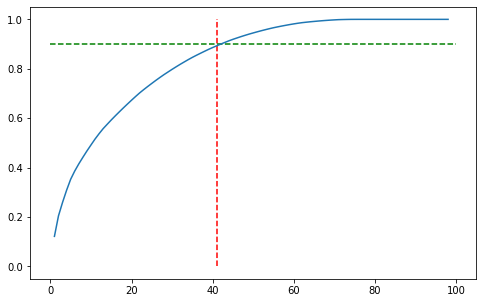

In [144]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(1,len(var_cumu)+1),var_cumu)
plt.vlines(x=41, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.90, xmax=100, xmin=0, colors="g", linestyles="--")
plt.show()

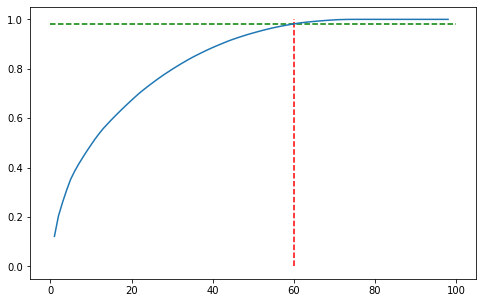

In [145]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(1,len(var_cumu)+1),var_cumu)
plt.vlines(x=60, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.98, xmax=100, xmin=0, colors="g", linestyles="--")
plt.show()

### Apply Logistic regression+PCA+SMOTE

In [146]:
scaler = StandardScaler()
pca = PCA(random_state=42)
smote = SMOTE(random_state = 42)
logistic = LogisticRegression(random_state=42,n_jobs=-1)

steps = [('scaler',scaler),('pca',pca),('smote',smote), ('logistic',logistic)]

LR_PCA = Pipeline(steps)

params = {'pca__n_components':[40,50,60,70],'logistic__C':[0.01,0.1,1,2,3,4,5,6,7,8,9,10,11,12]}

folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

model = GridSearchCV(estimator=LR_PCA, cv=folds, param_grid = params, scoring='roc_auc', n_jobs=-1)

In [147]:
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(random_state=42)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logistic',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                         10, 11, 12],
                         'pca__n_components': [40, 50, 60, 70]},
             scoring='roc_auc')

In [148]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8995965448818529
Best hyperparameters:  {'logistic__C': 0.01, 'pca__n_components': 70}


In [149]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_train_pred

array([0.10353551, 0.0310361 , 0.10533243, ..., 0.03864807, 0.7885348 ,
       0.00087246])

In [150]:
# create a data frame with target variable and probabilities
y_train_pred_prob = pd.DataFrame({'churn_user':y_train.values, 'churn_user_Prob':y_train_pred})
y_train_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.103536
1,0.0,0.031036
2,0.0,0.105332
3,0.0,0.374546
4,0.0,0.064837


In [151]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_train_pred_prob['churn_user_pred'] = y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.103536,0
1,0.0,0.031036,0
2,0.0,0.105332,0
3,0.0,0.374546,0
4,0.0,0.064837,0


In [152]:
# Check the distribution of probability, should be with in 0-1
y_train_pred_prob['churn_user_Prob'].describe()

count    1.861400e+04
mean     2.663671e-01
std      2.939190e-01
min      1.759953e-08
25%      2.666440e-02
50%      1.378753e-01
75%      4.390574e-01
max      9.996411e-01
Name: churn_user_Prob, dtype: float64

In [153]:
def confusion_matrix(confusion, actual_target, predicted_target):
    
    print(confusion,'\n')
 
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    print('Sensitivity (or) Recall score :', (TP / float(TP+FN)).round(2))
    print('Specificity:', (TN / float(TN+FP)).round(2))
    print('roc_auc_score:',roc_auc_score(actual_target, predicted_target).round(2))
    print('accuracy_score:',accuracy_score(actual_target, predicted_target).round(2))

In [154]:
print(classification_report(y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     17128
         1.0       0.30      0.83      0.44      1486

    accuracy                           0.83     18614
   macro avg       0.64      0.83      0.67     18614
weighted avg       0.93      0.83      0.87     18614



In [155]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)

[[14274  2854]
 [  247  1239]] 

Sensitivity (or) Recall score : 0.83
Specificity: 0.83
roc_auc_score: 0.83
accuracy_score: 0.83


#### Try to find optimal probability cutoff

In [156]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_prob[i]= y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.103536,0,1,1,0,0,0,0,0,0,0,0
1,0.0,0.031036,0,1,0,0,0,0,0,0,0,0,0
2,0.0,0.105332,0,1,1,0,0,0,0,0,0,0,0
3,0.0,0.374546,0,1,1,1,1,0,0,0,0,0,0
4,0.0,0.064837,0,1,0,0,0,0,0,0,0,0,0


In [157]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.079832  1.000000  0.000000
0.1   0.1  0.517406  0.967026  0.478398
0.2   0.2  0.642635  0.935397  0.617235
0.3   0.3  0.726926  0.913190  0.710766
0.4   0.4  0.785162  0.868102  0.777966
0.5   0.5  0.833405  0.833782  0.833372
0.6   0.6  0.871602  0.781292  0.879437
0.7   0.7  0.902869  0.727456  0.918087
0.8   0.8  0.924895  0.641319  0.949498
0.9   0.9  0.932846  0.380215  0.980792


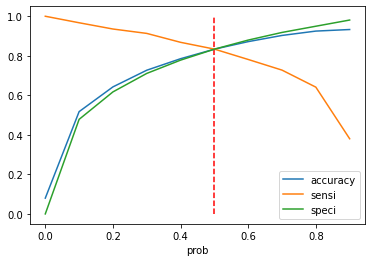

In [158]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.5, ymax=1, ymin=0, colors="r", linestyles="--")
plt.show()

In [159]:
# test set evaluation
y_test_pred = model.predict_proba(X_test)[:,1]
y_test_pred

array([0.58369515, 0.0906636 , 0.42612132, ..., 0.04036914, 0.08316953,
       0.01599874])

In [160]:
# create a data frame with target variable and probabilities
y_test_pred_prob = pd.DataFrame({'churn_user':y_test.values, 'churn_user_Prob':y_test_pred})
y_test_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.583695
1,0.0,0.090664
2,0.0,0.426121
3,0.0,0.013042
4,0.0,0.231658


In [161]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_test_pred_prob['churn_user_pred'] = y_test_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.583695,1
1,0.0,0.090664,0
2,0.0,0.426121,0
3,0.0,0.013042,0
4,0.0,0.231658,0


In [162]:
# Check the distribution of probability, should be with in 0-1
y_test_pred_prob['churn_user_Prob'].describe()

count    6.205000e+03
mean     2.701944e-01
std      2.952264e-01
min      6.275823e-07
25%      2.565642e-02
50%      1.430229e-01
75%      4.504782e-01
max      9.956080e-01
Name: churn_user_Prob, dtype: float64

In [163]:
print(classification_report(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      5710
         1.0       0.29      0.83      0.43       495

    accuracy                           0.83      6205
   macro avg       0.64      0.83      0.66      6205
weighted avg       0.93      0.83      0.86      6205



In [164]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)

[[4717  993]
 [  85  410]] 

Sensitivity (or) Recall score : 0.83
Specificity: 0.83
roc_auc_score: 0.83
accuracy_score: 0.83


In [165]:
joblib.dump(model,'LR_PCA_SMOTE.pkl')

['LR_PCA_SMOTE.pkl']

### Apply Logistic regression+SMOTE

In [166]:
scaler = StandardScaler()
smote = SMOTE(random_state = 42)
logistic = LogisticRegression(random_state=42,n_jobs=-1)

steps = [('scaler',scaler),('smote',smote), ('logistic',logistic)]

LR_SMT = Pipeline(steps)

params = {'logistic__C':[0.01,0.1,1,2,3,4,5,6,7,8,9,10,11,12]}

folds = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

model = GridSearchCV(estimator=LR_SMT, cv=folds, param_grid = params, scoring='roc_auc', n_jobs=-1)

In [167]:
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logistic',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                         10, 11, 12]},
             scoring='roc_auc')

In [168]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8996257416128064
Best hyperparameters:  {'logistic__C': 0.01}


In [169]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_train_pred

array([0.10380997, 0.03190927, 0.10990729, ..., 0.03931504, 0.79574121,
       0.00099656])

In [170]:
# create a data frame with target variable and probabilities
y_train_pred_prob = pd.DataFrame({'churn_user':y_train.values, 'churn_user_Prob':y_train_pred})
y_train_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.103810
1,0.0,0.031909
2,0.0,0.109907
3,0.0,0.368879
4,0.0,0.064595


In [171]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_train_pred_prob['churn_user_pred'] = y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.103810,0
1,0.0,0.031909,0
2,0.0,0.109907,0
3,0.0,0.368879,0
4,0.0,0.064595,0


In [172]:
# Check the distribution of probability, should be with in 0-1
y_train_pred_prob['churn_user_Prob'].describe()

count    1.861400e+04
mean     2.662535e-01
std      2.939652e-01
min      1.825606e-08
25%      2.654180e-02
50%      1.375944e-01
75%      4.376737e-01
max      9.996214e-01
Name: churn_user_Prob, dtype: float64

In [173]:
print(classification_report(y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     17128
         1.0       0.30      0.83      0.44      1486

    accuracy                           0.83     18614
   macro avg       0.64      0.83      0.67     18614
weighted avg       0.93      0.83      0.87     18614



In [174]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)

[[14287  2841]
 [  249  1237]] 

Sensitivity (or) Recall score : 0.83
Specificity: 0.83
roc_auc_score: 0.83
accuracy_score: 0.83


#### Try to find optimal probability cutoff

In [175]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_prob[i]= y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.103810,0,1,1,0,0,0,0,0,0,0,0
1,0.0,0.031909,0,1,0,0,0,0,0,0,0,0,0
2,0.0,0.109907,0,1,1,0,0,0,0,0,0,0,0
3,0.0,0.368879,0,1,1,1,1,0,0,0,0,0,0
4,0.0,0.064595,0,1,0,0,0,0,0,0,0,0,0


In [176]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.079832  1.000000  0.000000
0.1   0.1  0.518588  0.967699  0.479624
0.2   0.2  0.643440  0.936070  0.618052
0.3   0.3  0.727463  0.913190  0.711350
0.4   0.4  0.786720  0.871467  0.779367
0.5   0.5  0.833996  0.832436  0.834131
0.6   0.6  0.871978  0.782638  0.879729
0.7   0.7  0.903030  0.726783  0.918321
0.8   0.8  0.924251  0.637954  0.949089
0.9   0.9  0.933169  0.382907  0.980908


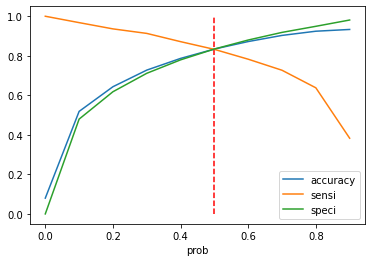

In [177]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.5, ymax=1, ymin=0, colors="r", linestyles="--")
plt.show()

In [178]:
# test set evaluation
y_test_pred = model.predict_proba(X_test)[:,1]
y_test_pred

array([0.57875176, 0.08858424, 0.4536997 , ..., 0.04043591, 0.08285691,
       0.01562604])

In [179]:
# create a data frame with target variable and probabilities
y_test_pred_prob = pd.DataFrame({'churn_user':y_test.values, 'churn_user_Prob':y_test_pred})
y_test_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.578752
1,0.0,0.088584
2,0.0,0.453700
3,0.0,0.012717
4,0.0,0.234055


In [180]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_test_pred_prob['churn_user_pred'] = y_test_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.578752,1
1,0.0,0.088584,0
2,0.0,0.453700,0
3,0.0,0.012717,0
4,0.0,0.234055,0


In [181]:
# Check the distribution of probability, should be with in 0-1
y_test_pred_prob['churn_user_Prob'].describe()

count    6.205000e+03
mean     2.701661e-01
std      2.954482e-01
min      6.393846e-07
25%      2.592196e-02
50%      1.414510e-01
75%      4.507074e-01
max      9.956051e-01
Name: churn_user_Prob, dtype: float64

In [182]:
print(classification_report(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      5710
         1.0       0.29      0.83      0.43       495

    accuracy                           0.83      6205
   macro avg       0.64      0.83      0.66      6205
weighted avg       0.93      0.83      0.86      6205



In [183]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)

[[4717  993]
 [  86  409]] 

Sensitivity (or) Recall score : 0.83
Specificity: 0.83
roc_auc_score: 0.83
accuracy_score: 0.83


### Apply Logistic regression

In [184]:
scaler = StandardScaler()
logistic = LogisticRegression(random_state=42,n_jobs=-1, class_weight='balance')

steps = [('scaler',scaler),('logistic',logistic)]

LR_ = Pipeline(steps)

params = {'logistic__C':[0.01,0.1,1,2,3,4,5,6,7,8,9,10,11,12]}

folds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

model = GridSearchCV(estimator=LR_SMT, cv=folds, param_grid = params, scoring='roc_auc', n_jobs=-1)

In [185]:
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('logistic',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                         10, 11, 12]},
             scoring='roc_auc')

In [186]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8996257416128064
Best hyperparameters:  {'logistic__C': 0.01}


In [187]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_train_pred

array([0.10380997, 0.03190927, 0.10990729, ..., 0.03931504, 0.79574121,
       0.00099656])

In [188]:
# create a data frame with target variable and probabilities
y_train_pred_prob = pd.DataFrame({'churn_user':y_train.values, 'churn_user_Prob':y_train_pred})
y_train_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.103810
1,0.0,0.031909
2,0.0,0.109907
3,0.0,0.368879
4,0.0,0.064595


In [189]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_train_pred_prob['churn_user_pred'] = y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.103810,0
1,0.0,0.031909,0
2,0.0,0.109907,0
3,0.0,0.368879,0
4,0.0,0.064595,0


In [190]:
# Check the distribution of probability, should be with in 0-1
y_train_pred_prob['churn_user_Prob'].describe()

count    1.861400e+04
mean     2.662535e-01
std      2.939652e-01
min      1.825606e-08
25%      2.654180e-02
50%      1.375944e-01
75%      4.376737e-01
max      9.996214e-01
Name: churn_user_Prob, dtype: float64

In [191]:
print(classification_report(y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     17128
         1.0       0.30      0.83      0.44      1486

    accuracy                           0.83     18614
   macro avg       0.64      0.83      0.67     18614
weighted avg       0.93      0.83      0.87     18614



In [192]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)

[[14287  2841]
 [  249  1237]] 

Sensitivity (or) Recall score : 0.83
Specificity: 0.83
roc_auc_score: 0.83
accuracy_score: 0.83


#### Try to find optimal probability cutoff

In [193]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_prob[i]= y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.103810,0,1,1,0,0,0,0,0,0,0,0
1,0.0,0.031909,0,1,0,0,0,0,0,0,0,0,0
2,0.0,0.109907,0,1,1,0,0,0,0,0,0,0,0
3,0.0,0.368879,0,1,1,1,1,0,0,0,0,0,0
4,0.0,0.064595,0,1,0,0,0,0,0,0,0,0,0


In [194]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.079832  1.000000  0.000000
0.1   0.1  0.518588  0.967699  0.479624
0.2   0.2  0.643440  0.936070  0.618052
0.3   0.3  0.727463  0.913190  0.711350
0.4   0.4  0.786720  0.871467  0.779367
0.5   0.5  0.833996  0.832436  0.834131
0.6   0.6  0.871978  0.782638  0.879729
0.7   0.7  0.903030  0.726783  0.918321
0.8   0.8  0.924251  0.637954  0.949089
0.9   0.9  0.933169  0.382907  0.980908


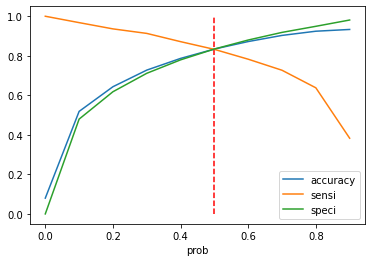

In [195]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.5, ymax=1, ymin=0, colors="r", linestyles="--")
plt.show()

In [196]:
# test set evaluation
y_test_pred = model.predict_proba(X_test)[:,1]
y_test_pred

array([0.57875176, 0.08858424, 0.4536997 , ..., 0.04043591, 0.08285691,
       0.01562604])

In [197]:
# create a data frame with target variable and probabilities
y_test_pred_prob = pd.DataFrame({'churn_user':y_test.values, 'churn_user_Prob':y_test_pred})
y_test_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.578752
1,0.0,0.088584
2,0.0,0.453700
3,0.0,0.012717
4,0.0,0.234055


In [198]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_test_pred_prob['churn_user_pred'] = y_test_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.578752,1
1,0.0,0.088584,0
2,0.0,0.453700,0
3,0.0,0.012717,0
4,0.0,0.234055,0


In [199]:
# Check the distribution of probability, should be with in 0-1
y_test_pred_prob['churn_user_Prob'].describe()

count    6.205000e+03
mean     2.701661e-01
std      2.954482e-01
min      6.393846e-07
25%      2.592196e-02
50%      1.414510e-01
75%      4.507074e-01
max      9.956051e-01
Name: churn_user_Prob, dtype: float64

In [200]:
print(classification_report(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90      5710
         1.0       0.29      0.83      0.43       495

    accuracy                           0.83      6205
   macro avg       0.64      0.83      0.66      6205
weighted avg       0.93      0.83      0.86      6205



In [201]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)

[[4717  993]
 [  86  409]] 

Sensitivity (or) Recall score : 0.83
Specificity: 0.83
roc_auc_score: 0.83
accuracy_score: 0.83


### Apply Random Forest Classifier

In [230]:
rfc = RandomForestClassifier(random_state=42,n_jobs=-1, criterion= 'entropy', class_weight='balanced')

params = {'n_estimators':range(500,700,50),'max_depth':range(2,7)}

folds = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

model = GridSearchCV(estimator=rfc, cv=folds, param_grid = params, scoring='roc_auc', n_jobs=-1)

In [231]:
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy', n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 7),
                         'n_estimators': range(500, 700, 50)},
             scoring='roc_auc')

In [268]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.9316091712534067
Best hyperparameters:  {'max_depth': 6, 'n_estimators': 600}


In [269]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_train_pred

array([0.19591093, 0.06129569, 0.31406872, ..., 0.06732909, 0.34690518,
       0.10286181])

In [270]:
# create a data frame with target variable and probabilities
y_train_pred_prob = pd.DataFrame({'churn_user':y_train.values, 'churn_user_Prob':y_train_pred})
y_train_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.195911
1,0.0,0.061296
2,0.0,0.314069
3,0.0,0.186094
4,0.0,0.193588


In [271]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_train_pred_prob['churn_user_pred'] = y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.195911,0
1,0.0,0.061296,0
2,0.0,0.314069,0
3,0.0,0.186094,0
4,0.0,0.193588,0


In [272]:
# Check the distribution of probability, should be with in 0-1
y_train_pred_prob['churn_user_Prob'].describe()

count    18614.000000
mean         0.247745
std          0.238692
min          0.025288
25%          0.091695
50%          0.148434
75%          0.302898
max          0.979382
Name: churn_user_Prob, dtype: float64

In [273]:
print(classification_report(y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95     17128
         1.0       0.49      0.85      0.62      1486

    accuracy                           0.92     18614
   macro avg       0.74      0.89      0.79     18614
weighted avg       0.95      0.92      0.93     18614



In [274]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)

[[15828  1300]
 [  226  1260]] 

Sensitivity (or) Recall score : 0.85
Specificity: 0.92
roc_auc_score: 0.89
accuracy_score: 0.92


#### Try to find optimal probability cutoff

In [275]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_prob[i]= y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.195911,0,1,1,0,0,0,0,0,0,0,0
1,0.0,0.061296,0,1,0,0,0,0,0,0,0,0,0
2,0.0,0.314069,0,1,1,1,1,0,0,0,0,0,0
3,0.0,0.186094,0,1,1,0,0,0,0,0,0,0,0
4,0.0,0.193588,0,1,1,0,0,0,0,0,0,0,0


In [276]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.079832  1.000000  0.000000
0.1   0.1  0.374073  0.998654  0.319886
0.2   0.2  0.698023  0.981830  0.673400
0.3   0.3  0.819598  0.948856  0.808384
0.4   0.4  0.883099  0.898385  0.881773
0.5   0.5  0.918019  0.847914  0.924101
0.6   0.6  0.936661  0.767833  0.951308
0.7   0.7  0.947137  0.671602  0.971042
0.8   0.8  0.948587  0.574024  0.981084
0.9   0.9  0.945579  0.465680  0.987214


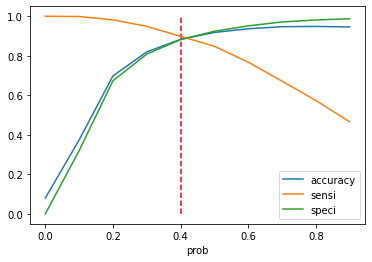

In [277]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.show()

In [278]:
# test set evaluation
y_test_pred = model.predict_proba(X_test)[:,1]
y_test_pred

array([0.43607201, 0.11493294, 0.11907281, ..., 0.08113786, 0.07418501,
       0.10678916])

In [279]:
# create a data frame with target variable and probabilities
y_test_pred_prob = pd.DataFrame({'churn_user':y_test.values, 'churn_user_Prob':y_test_pred})
y_test_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.436072
1,0.0,0.114933
2,0.0,0.119073
3,0.0,0.081721
4,0.0,0.148221


In [280]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_test_pred_prob['churn_user_pred'] = y_test_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.4 else 0)
y_test_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.436072,1
1,0.0,0.114933,0
2,0.0,0.119073,0
3,0.0,0.081721,0
4,0.0,0.148221,0


In [281]:
# Check the distribution of probability, should be with in 0-1
y_test_pred_prob['churn_user_Prob'].describe()

count    6205.000000
mean        0.251294
std         0.238555
min         0.025893
25%         0.094454
50%         0.151767
75%         0.308091
max         0.978776
Name: churn_user_Prob, dtype: float64

In [282]:
print(classification_report(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92      5710
         1.0       0.36      0.85      0.51       495

    accuracy                           0.87      6205
   macro avg       0.67      0.86      0.72      6205
weighted avg       0.94      0.87      0.89      6205



In [283]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)

[[4973  737]
 [  75  420]] 

Sensitivity (or) Recall score : 0.85
Specificity: 0.87
roc_auc_score: 0.86
accuracy_score: 0.87


In [285]:
joblib.dump(model,'rfc.pkl')

['rfc.pkl']

### Apply Random Forest Classifier+SMOTE

In [286]:
smote = SMOTE(random_state = 42)
rfc = RandomForestClassifier(random_state=42,n_jobs=-1, criterion= 'entropy')

steps = [('smote',smote),('rfc',rfc)]

rfc = Pipeline(steps)

params = {'rfc__n_estimators':range(500,700,50),'rfc__max_depth':range(2,7)}

folds = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)

model = GridSearchCV(estimator=rfc, cv=folds, param_grid = params, scoring='roc_auc', n_jobs=-1)

In [287]:
model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('rfc',
                                        RandomForestClassifier(criterion='entropy',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': range(2, 7),
                         'rfc__n_estimators': range(500, 700, 50)},
             scoring='roc_auc')

In [288]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.9279238674984202
Best hyperparameters:  {'rfc__max_depth': 6, 'rfc__n_estimators': 550}


In [289]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_train_pred

array([0.14622734, 0.05165336, 0.464805  , ..., 0.06061501, 0.30215234,
       0.06118665])

In [290]:
# create a data frame with target variable and probabilities
y_train_pred_prob = pd.DataFrame({'churn_user':y_train.values, 'churn_user_Prob':y_train_pred})
y_train_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.146227
1,0.0,0.051653
2,0.0,0.464805
3,0.0,0.157512
4,0.0,0.153044


In [291]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_train_pred_prob['churn_user_pred'] = y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.146227,0
1,0.0,0.051653,0
2,0.0,0.464805,0
3,0.0,0.157512,0
4,0.0,0.153044,0


In [292]:
# Check the distribution of probability, should be with in 0-1
y_train_pred_prob['churn_user_Prob'].describe()

count    18614.000000
mean         0.237841
std          0.246015
min          0.016309
25%          0.074570
50%          0.132418
75%          0.302228
max          0.972912
Name: churn_user_Prob, dtype: float64

In [293]:
print(classification_report(y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     17128
         1.0       0.47      0.81      0.60      1486

    accuracy                           0.91     18614
   macro avg       0.73      0.87      0.78     18614
weighted avg       0.94      0.91      0.92     18614



In [294]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_train_pred_prob.churn_user,y_train_pred_prob.churn_user_pred)

[[15792  1336]
 [  278  1208]] 

Sensitivity (or) Recall score : 0.81
Specificity: 0.92
roc_auc_score: 0.87
accuracy_score: 0.91


#### Try to find optimal probability cutoff

In [295]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_prob[i]= y_train_pred_prob.churn_user_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.146227,0,1,1,0,0,0,0,0,0,0,0
1,0.0,0.051653,0,1,0,0,0,0,0,0,0,0,0
2,0.0,0.464805,0,1,1,1,1,1,0,0,0,0,0
3,0.0,0.157512,0,1,1,0,0,0,0,0,0,0,0
4,0.0,0.153044,0,1,1,0,0,0,0,0,0,0,0


In [296]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_prob.churn_user, y_train_pred_prob[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.079832  1.000000  0.000000
0.1   0.1  0.460352  0.993271  0.414117
0.2   0.2  0.717417  0.962988  0.696112
0.3   0.3  0.815676  0.921938  0.806457
0.4   0.4  0.874987  0.874832  0.875000
0.5   0.5  0.913291  0.812921  0.921999
0.6   0.6  0.930482  0.742261  0.946812
0.7   0.7  0.938380  0.664199  0.962167
0.8   0.8  0.943537  0.582100  0.974895
0.9   0.9  0.944074  0.448183  0.987097


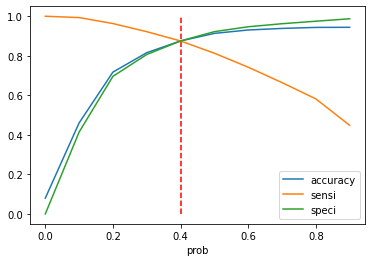

In [297]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.vlines(x=0.4, ymax=1, ymin=0, colors="r", linestyles="--")
plt.show()

In [298]:
# test set evaluation
y_test_pred = model.predict_proba(X_test)[:,1]
y_test_pred

array([0.55847915, 0.06580339, 0.13844198, ..., 0.0782337 , 0.04908181,
       0.05482045])

In [299]:
# create a data frame with target variable and probabilities
y_test_pred_prob = pd.DataFrame({'churn_user':y_test.values, 'churn_user_Prob':y_test_pred})
y_test_pred_prob.head()

,churn_user,churn_user_Prob
0,0.0,0.558479
1,0.0,0.065803
2,0.0,0.138442
3,0.0,0.043855
4,0.0,0.103791


In [300]:
# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.5 else 0
y_test_pred_prob['churn_user_pred'] = y_test_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.4 else 0)
y_test_pred_prob.head()

,churn_user,churn_user_Prob,churn_user_pred
0,0.0,0.558479,1
1,0.0,0.065803,0
2,0.0,0.138442,0
3,0.0,0.043855,0
4,0.0,0.103791,0


In [301]:
# Check the distribution of probability, should be with in 0-1
y_test_pred_prob['churn_user_Prob'].describe()

count    6205.000000
mean        0.242035
std         0.246453
min         0.018458
25%         0.077661
50%         0.135830
75%         0.311615
max         0.974211
Name: churn_user_Prob, dtype: float64

In [302]:
print(classification_report(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)) # check the classification report

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92      5710
         1.0       0.35      0.85      0.50       495

    accuracy                           0.86      6205
   macro avg       0.67      0.86      0.71      6205
weighted avg       0.94      0.86      0.89      6205



In [303]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred )

#confusion_matrix(confusion, actual_target, predicted_target):
confusion_matrix(confusion,y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred)

[[4933  777]
 [  72  423]] 

Sensitivity (or) Recall score : 0.85
Specificity: 0.86
roc_auc_score: 0.86
accuracy_score: 0.86


In [304]:
#joblib.dump(model,'model/rfc_smote.pkl')

['rfc_smote.pkl']

In [142]:
load_best_model = joblib.load('models/rfc.pkl')

In [143]:
RFC = RandomForestClassifier()

RFC.set_params(**load_best_model.best_estimator_.get_params())

RFC.fit(X_train,y_train)

# test set evaluation
y_test_pred = RFC.predict_proba(X_test)[:,1]

# create a data frame with target variable and probabilities
y_test_pred_prob = pd.DataFrame({'churn_user':y_test.values, 'churn_user_Prob':y_test_pred})

# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.4 else 0
y_test_pred_prob['churn_user_pred'] = y_test_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.4 else 0)

# Confusion matrix 
confusion = metrics.confusion_matrix(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred )

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Sensitivity (or) Recall score :', (TP / float(TP+FN)).round(2))
print('Specificity:', (TN / float(TN+FP)).round(2))
print('roc_auc_score:',roc_auc_score(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred ).round(2))
print('accuracy_score:',accuracy_score(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred ).round(2))

Sensitivity (or) Recall score : 0.85
Specificity: 0.87
roc_auc_score: 0.86
accuracy_score: 0.87


In [144]:
rfc_imp_features_tst = pd.DataFrame(list(zip(list(X_train.columns),list(RFC.feature_importances_))),
                                columns=['Feature_name','Feature_importance']).sort_values(by='Feature_importance', 
                                                                                           ascending=False)

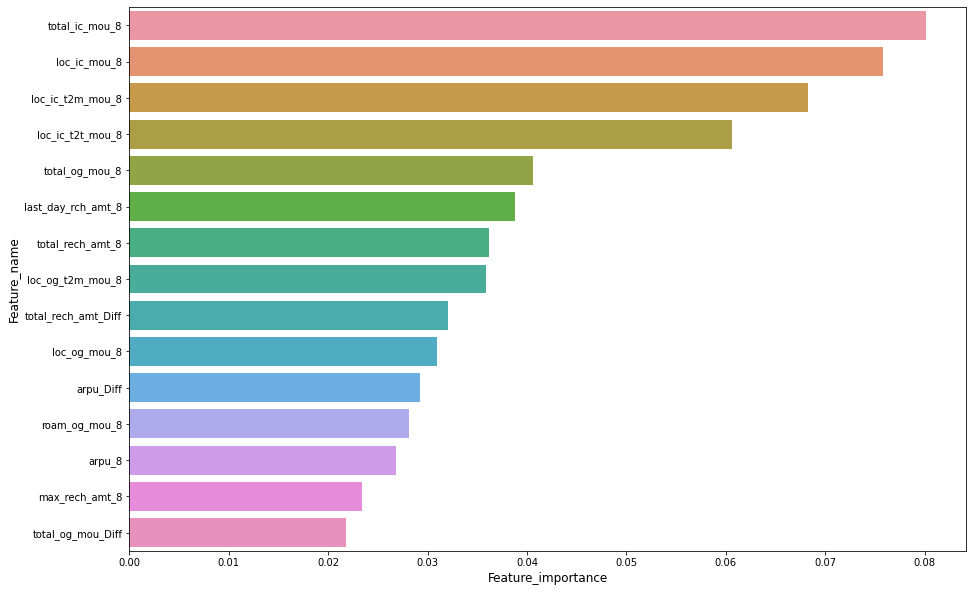

In [562]:
plt.figure(figsize=(15,10))
params = {'axes.labelsize': 12}
plt.rcParams.update(params)
sns.barplot(y='Feature_name',x='Feature_importance', data=rfc_imp_features_tst[:15])
plt.show()

In [145]:
Top_15_Features = rfc_imp_features_tst.Feature_name[:15].values.tolist()

In [146]:
Top_15_Features

['total_ic_mou_8',
 'loc_ic_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2t_mou_8',
 'total_og_mou_8',
 'last_day_rch_amt_8',
 'total_rech_amt_8',
 'loc_og_t2m_mou_8',
 'total_rech_amt_Diff',
 'loc_og_mou_8',
 'arpu_Diff',
 'roam_og_mou_8',
 'arpu_8',
 'max_rech_amt_8',
 'total_og_mou_Diff']

In [147]:
RFC.fit(X_train[Top_15_Features],y_train)

# test set evaluation
y_test_pred = RFC.predict_proba(X_test[Top_15_Features])[:,1]

# create a data frame with target variable and probabilities
y_test_pred_prob = pd.DataFrame({'churn_user':y_test.values, 'churn_user_Prob':y_test_pred})

# create new columns 'churn_user_pred' by using 'churn_user_Prob' values. 1 if churn_user_Prob > 0.4 else 0
y_test_pred_prob['churn_user_pred'] = y_test_pred_prob.churn_user_Prob.map(lambda x: 1 if x > 0.4 else 0)

# Confusion matrix 
confusion = metrics.confusion_matrix(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred )

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Sensitivity (or) Recall score :', (TP / float(TP+FN)).round(2))
print('Specificity:', (TN / float(TN+FP)).round(2))
print('roc_auc_score:',roc_auc_score(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred ).round(2))
print('accuracy_score:',accuracy_score(y_test_pred_prob.churn_user, y_test_pred_prob.churn_user_pred ).round(2))

Sensitivity (or) Recall score : 0.85
Specificity: 0.85
roc_auc_score: 0.85
accuracy_score: 0.85


In [586]:
joblib.dump(RFC, 'models/Model.pkl')

['models/Model_.pkl']

In [155]:
df_prep[Top_15_Features].describe()

,total_ic_mou_8,loc_ic_mou_8,loc_ic_t2m_mou_8,loc_ic_t2t_mou_8,total_og_mou_8,last_day_rch_amt_8,total_rech_amt_8,loc_og_t2m_mou_8,total_rech_amt_Diff,loc_og_mou_8,arpu_Diff,roam_og_mou_8,arpu_8,max_rech_amt_8,total_og_mou_Diff
count,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000,24819.000000
mean,228.693174,195.411576,133.944121,50.136555,507.136227,82.099198,517.738426,141.796506,83.370361,208.453800,58.992165,12.129068,451.173344,142.930739,75.135282
std,246.959311,230.461443,175.144505,82.077309,587.597889,102.182201,396.293889,206.358729,318.889933,278.518792,256.304909,47.817884,329.157923,119.515614,421.019664
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2551.000000,0.000000,-2192.724500,0.000000,-345.129000,0.000000,-2821.165000
25%,56.620000,38.850000,23.440000,4.690000,63.745000,0.000000,233.000000,12.130000,-83.000000,20.400000,-69.787500,0.000000,214.884000,50.000000,-59.077500
50%,156.040000,121.840000,76.530000,21.560000,317.610000,44.000000,457.000000,63.480000,60.500000,102.880000,44.293500,0.000000,403.341000,130.000000,14.830000
75%,313.970000,266.035000,175.360000,61.190000,746.870000,130.000000,720.000000,188.545000,234.000000,289.850000,173.679750,0.000000,613.207000,175.000000,163.210000
max,2298.730000,2109.440000,1803.410000,932.960000,4838.890000,1000.000000,3954.000000,2073.760000,2345.000000,2549.840000,2132.446000,533.910000,3298.630000,1100.000000,4067.155000
